In [1]:
# A method from Rohan to train Q learners
import random
from numpy import random as rnd
import matplotlib.pyplot as plt
import numpy as np
import pytz
import datetime
import os

STAY = 0
LEAVE = 1
ITI = [0,0]

In [2]:
def cdf(x,N0):
    A = -.125
    return 1+ N0 * 1/A * np.exp(A*x) - N0/A

def pdf(this_cdf):
    this_pdf = []
    for t in range(1,len(this_cdf)):
        this_pdf.append(this_cdf[t]-this_cdf[t-1])
    this_pdf.insert(0,1) # add that first reward
    return this_pdf

In [3]:
# q_learner.py
# Basic reinforcement learning classes

# Class for RL Environment
# this class both contains environment information and makes choices
class Environment:
    def __init__(self, nstate=3, naction=2):
        self.Ns = nstate   # number of states
        self.Na = naction  # number of actions
        self.state = 0 # ITI

    # This method carries out an action on behalf of the agent and updates environment information, 'action' is the action to be carried out
    def take_action(self, action):
        reward = 0
        self.state = self.state
        return self.state, reward

#------------------------------------------------------------------------------------------#

# Class for Forager RL Agent
# A slight specialization so that we can use the fact that we only ever have 2 actions: 
# STAY/STOP = 0, LEAVE/RUN = 1
# This should generalize by taking in nActions and nStates from the specialized environment
class ForagerAgent:
    def __init__(self,nObservationStates,nTimeStates,learning_rate=0.1, discount=0.95, exploration_rate=0.3, trials=2000):
        self.q_table = [np.zeros((1+nObservationStates,nTimeStates)),np.zeros((1+nObservationStates, nTimeStates))] # List of (Q-table) for rewards accounting
        self.learning_rate = learning_rate # How much we appreciate new q-value over current
        self.discount = discount # How much we appreciate future reward over current
        self.exploration_rate = exploration_rate # Initial exploration rate
        self.trials = trials # Number of Trials per learning episode

    def get_next_action(self, state):
        if random.random() > self.exploration_rate: # Explore (gamble) or exploit (greedy)
            return self.greedy_action(tuple(state))
        else:
            return self.random_action()

    # No stochasticity; all in random action taking at exploration_rate
    def greedy_action(self, state):
        # Is STAY reward bigger?
        print('greedy_action state',state)
        if self.q_table[STAY][state] > self.q_table[LEAVE][state]:
            return STAY
        # Is LEAVE reward bigger?
        elif self.q_table[LEAVE][state] > self.q_table[STAY][state]:
            return LEAVE
        # Rewards are equal, take random action
        return STAY if random.random() < 0.5 else LEAVE

    def random_action(self):
        return STAY if random.random() < 0.5 else LEAVE

    def update(self, old_state, new_state, action, reward):
        # Old Q-table value
        old_value = self.q_table[action][old_state]
        # Select next best action...
        future_action = self.greedy_action(new_state)
        # What is reward for the best next action?
        future_reward = self.q_table[future_action][new_state]

        # Main Q-table updating algorithm
        new_value = old_value + self.learning_rate * (reward + self.discount * future_reward - old_value)

        self.q_table[action][old_state] = new_value
        print('update old_state',old_state,new_value)
        print('update action',action)


In [45]:
# The specific patch foraging environment (actor is completely general)
class patchF_timerDet(Environment):
    """
    Virtual foraging environment
    Deterministic reward on a schedule determined by integer values of the CDF
    
    """
    def __init__(self, nstate=int(3*50), naction=2,rew_system = 'deterministic',speed = 5,ITI_len = 50,runcost = -.2):
        super().__init__(nstate, naction) # override our general init
        self.rew_system = rew_system
        self.rew_size = [1, 2, 4]
        self.stay_times = dict()
        self.state = ITI
        self.speed = speed # for ITI
        self.dist_to_patch = ITI_len
        self.max_patch = 50 # get kicked off the patch
        self.N0 = [.5, .25, .125]
        self.pdfs = dict()
        self.nObsStates = 3 # rew sizes
        self.nTimeStates = 50 # timestates
        self.PRTs = {0:[],1:[],2:[],3:[],4:[]}
        self.runcost = runcost
        self.ITI_len = ITI_len
        
        for n0 in self.N0:
            x = list(map(cdf,list(range(50)),np.full(50,n0)))
            self.pdfs[n0] = pdf(x)
    
    # super discretized expo dist methods
    def cdf(x,N0):
        A = -.125
        return 1+ N0 * 1/A * np.exp(A*x) - N0/A
    def pdf(this_cdf):
        this_pdf = []
        for t in range(1,len(this_cdf)):
            this_pdf.append(this_cdf[t]-this_cdf[t-1])
        this_pdf.insert(0,1) # add that first reward
        return this_pdf

    # Reset the patch, determine rew location freq, size, and rew_locs
    def determine_patch(self):
        self.rew_locs = np.zeros(50)
        this_rew_state = rnd.choice(len(self.rew_size))
        this_freq_state = rnd.choice(len(self.N0))
        self.this_rew_size = self.rew_size[this_rew_state]
        self.this_freq = self.N0[this_freq_state]
        self.state = [this_rew_state+1,0] # rew size, 0 time stayed on... add 1 so we stay out of iti
        if self.rew_system == 'deterministic':
            self.rew_locs[[1,4,16]] = 1
        if self.rew_system == 'probabilistic':
            loc_list = np.where(rnd.random(50) - self.pdfs[self.this_freq] < 0)[0].tolist()
            self.rew_locs[loc_list] = 1
        print('New patch!',self.state)
        return self.state,0 # change the state, give 0 reward
            
    def take_action(self, action):
        """step by an action
           takes in action chosen by agent
           return [new_state, reward]"""
        # We're staying on a patch, let's see if we get a reward
        if action == STAY and self.state != ITI: # see if we get a reward
            if self.state[1] < self.max_patch:
                self.state[1] += 1 # add one step to our time state
                this_time = self.state[1]
                if self.rew_locs[this_time] == 1: 
                    return self.state,self.this_rew_size # we got a reward! 
                # Otherwise, just return no reward ... change this?
                else:
                    return self.state, 0
            else:
                return ITI,0
     
        # We're leaving the patch, getting sent to ITI
        if action == LEAVE and self.state != ITI:
            (self.PRTs[self.state[0]]).append(self.state[1])
            return ITI,self.runcost
        
        # This is kinda just to get a sense of the 
        if action == STAY and self.state == ITI:
            return ITI,0 # if we sit during the ITI, we just stay where we are
        
        if action == LEAVE and self.state == ITI:
            self.stay_times[self.this_rew_size] = self.state[1]
            self.dist_to_patch -= self.speed # run towards the patch
            if self.dist_to_patch <= 0: # we made it to the end! let's reset the patch
                self.dist_to_patch = self.ITI_len
                return self.determine_patch()
            else:
                return self.state,self.runcost



In [46]:
# This will turn into runner.py

# The following variables will help in tracking values for data analysis/graphing
# observations = list(range(0,11)) # 0-10
# states_visited = {key:0 for key in observations}
stay_qvalues = list()
leave_qvalues = list()
leave_times = list()
reward_over_time = []

behavior_mats = {0:[],1:[],2:[],3:[]}

# setup simulation
det_env = patchF_timerDet(rew_system = 'probabilistic') # Make the environment first, then feed the agent its parameters
det_agent = ForagerAgent(det_env.nObsStates,det_env.nTimeStates)

total_reward = 0 # Score keeping
rews = []
locations = []
actions = []

count = 0
# main loop
det_env.determine_patch()
while count < det_agent.trials:

    """Just to later visualize where rewards were"""
    locations.append(det_env.rew_locs)

    old_state = det_env.state
    action = det_agent.get_next_action(old_state)
    actions.append(action)
    new_state, reward = det_env.take_action(action)
    rews.append(reward)
    print('new_state,reward',new_state,reward)

    # This means we finished a trial
    if action == LEAVE and old_state != ITI:
        leave_times.append(old_state)
        behavior_mats[old_state[0]].append(list(np.hstack((np.ones(old_state[1]),np.zeros(50 - (old_state[1]))))))
        print('Trial ',count,' complete.')
        count += 1
        det_env.determine_patch()

    det_agent.update(tuple(old_state), tuple(new_state), action, reward)
    print('count',count)
    print('old_state,new_state,action,det_env.state[1]',  old_state, new_state, action, det_env.state[1])
    # print(agent.q_table)
    # time.sleep(.1)
    total_reward += reward
    reward_over_time.append((count, total_reward))

#     # do some visualization here

# # #------------------------------------------------------------------------------------------#

# if __name__ == "__main__":
#     main()

# #------------------------------------------------------------------------------------------#


New patch! [2, 0]
greedy_action state (2, 0)
new_state,reward [0, 0] -0.2
Trial  0  complete.
New patch! [2, 0]
greedy_action state (0, 0)
update old_state (2, 0) -0.020000000000000004
update action 1
count 1
old_state,new_state,action,det_env.state[1] [2, 0] [0, 0] 1 0
greedy_action state (2, 0)
new_state,reward [2, 1] 0
greedy_action state (2, 1)
update old_state (2, 1) 0.0
update action 0
count 1
old_state,new_state,action,det_env.state[1] [2, 1] [2, 1] 0 1
greedy_action state (2, 1)
new_state,reward [0, 0] -0.2
Trial  1  complete.
New patch! [2, 0]
greedy_action state (0, 0)
update old_state (2, 1) -0.020000000000000004
update action 1
count 2
old_state,new_state,action,det_env.state[1] [2, 1] [0, 0] 1 0
greedy_action state (2, 0)
new_state,reward [2, 1] 0
greedy_action state (2, 1)
update old_state (2, 1) 0.0
update action 0
count 2
old_state,new_state,action,det_env.state[1] [2, 1] [2, 1] 0 1
greedy_action state (2, 1)
new_state,reward [2, 2] 0
greedy_action state (2, 2)
update o

old_state,new_state,action,det_env.state[1] [1, 4] [0, 0] 1 0
new_state,reward [0, 0] -0.2
Trial  37  complete.
New patch! [1, 0]
greedy_action state (0, 0)
update old_state (2, 0) -0.081902
update action 1
count 38
old_state,new_state,action,det_env.state[1] [2, 0] [0, 0] 1 0
greedy_action state (1, 0)
new_state,reward [1, 1] 0
greedy_action state (1, 1)
update old_state (1, 1) 0.19652243756249999
update action 0
count 38
old_state,new_state,action,det_env.state[1] [1, 1] [1, 1] 0 1
new_state,reward [0, 0] -0.2
Trial  38  complete.
New patch! [2, 0]
greedy_action state (0, 0)
update old_state (1, 1) -0.05420000000000001
update action 1
count 39
old_state,new_state,action,det_env.state[1] [1, 1] [0, 0] 1 0
new_state,reward [0, 0] -0.2
Trial  39  complete.
New patch! [2, 0]
greedy_action state (0, 0)
update old_state (2, 0) -0.09371180000000001
update action 1
count 40
old_state,new_state,action,det_env.state[1] [2, 0] [0, 0] 1 0
new_state,reward [2, 1] 2
greedy_action state (2, 1)
upda

update old_state (2, 1) 0.5650639470086434
update action 0
count 59
old_state,new_state,action,det_env.state[1] [2, 1] [2, 1] 0 1
greedy_action state (2, 1)
new_state,reward [2, 2] 2
greedy_action state (2, 2)
update old_state (2, 2) 0.5930547506243751
update action 0
count 59
old_state,new_state,action,det_env.state[1] [2, 2] [2, 2] 0 2
greedy_action state (2, 2)
new_state,reward [2, 3] 0
greedy_action state (2, 3)
update old_state (2, 3) 0.5784049454495857
update action 0
count 59
old_state,new_state,action,det_env.state[1] [2, 3] [2, 3] 0 3
new_state,reward [2, 4] 0
greedy_action state (2, 4)
update old_state (2, 4) 0.3920795018712532
update action 0
count 59
old_state,new_state,action,det_env.state[1] [2, 4] [2, 4] 0 4
greedy_action state (2, 4)
new_state,reward [2, 5] 0
greedy_action state (2, 5)
update old_state (2, 5) 0.0
update action 0
count 59
old_state,new_state,action,det_env.state[1] [2, 5] [2, 5] 0 5
new_state,reward [2, 6] 0
greedy_action state (2, 6)
update old_state (2

old_state,new_state,action,det_env.state[1] [3, 3] [3, 3] 0 3
greedy_action state (3, 3)
new_state,reward [3, 4] 4
greedy_action state (3, 4)
update old_state (3, 4) 0.7804440521863087
update action 0
count 83
old_state,new_state,action,det_env.state[1] [3, 4] [3, 4] 0 4
greedy_action state (3, 4)
new_state,reward [3, 5] 0
greedy_action state (3, 5)
update old_state (3, 5) 0.0
update action 0
count 83
old_state,new_state,action,det_env.state[1] [3, 5] [3, 5] 0 5
greedy_action state (3, 5)
new_state,reward [3, 6] 4
greedy_action state (3, 6)
update old_state (3, 6) 0.7940299500000001
update action 0
count 83
old_state,new_state,action,det_env.state[1] [3, 6] [3, 6] 0 6
greedy_action state (3, 6)
new_state,reward [3, 7] 4
greedy_action state (3, 7)
update old_state (3, 7) 0.4
update action 0
count 83
old_state,new_state,action,det_env.state[1] [3, 7] [3, 7] 0 7
greedy_action state (3, 7)
new_state,reward [3, 8] 0
greedy_action state (3, 8)
update old_state (3, 8) 0.0
update action 0
coun

old_state,new_state,action,det_env.state[1] [3, 2] [3, 2] 0 2
greedy_action state (3, 2)
new_state,reward [3, 3] 4
greedy_action state (3, 3)
update old_state (3, 3) 1.907783914173034
update action 0
count 103
old_state,new_state,action,det_env.state[1] [3, 3] [3, 3] 0 3
greedy_action state (3, 3)
new_state,reward [3, 4] 0
greedy_action state (3, 4)
update old_state (3, 4) 0.761127088776081
update action 0
count 103
old_state,new_state,action,det_env.state[1] [3, 4] [3, 4] 0 4
greedy_action state (3, 4)
new_state,reward [3, 5] 0
greedy_action state (3, 5)
update old_state (3, 5) 0.0
update action 0
count 103
old_state,new_state,action,det_env.state[1] [3, 5] [3, 5] 0 5
greedy_action state (3, 5)
new_state,reward [3, 6] 0
greedy_action state (3, 6)
update old_state (3, 6) 0.7782680589737938
update action 0
count 103
old_state,new_state,action,det_env.state[1] [3, 6] [3, 6] 0 6
greedy_action state (3, 6)
new_state,reward [3, 7] 0
greedy_action state (3, 7)
update old_state (3, 7) 0.78608

old_state,new_state,action,det_env.state[1] [1, 7] [1, 7] 0 7
greedy_action state (1, 7)
new_state,reward [1, 8] 0
greedy_action state (1, 8)
update old_state (1, 8) 0.0985074875
update action 0
count 129
old_state,new_state,action,det_env.state[1] [1, 8] [1, 8] 0 8
greedy_action state (1, 8)
new_state,reward [1, 9] 0
greedy_action state (1, 9)
update old_state (1, 9) 0.09801495006250001
update action 0
count 129
old_state,new_state,action,det_env.state[1] [1, 9] [1, 9] 0 9
greedy_action state (1, 9)
new_state,reward [1, 10] 0
greedy_action state (1, 10)
update old_state (1, 10) 0.0
update action 0
count 129
old_state,new_state,action,det_env.state[1] [1, 10] [1, 10] 0 10
new_state,reward [1, 11] 0
greedy_action state (1, 11)
update old_state (1, 11) 0.0
update action 0
count 129
old_state,new_state,action,det_env.state[1] [1, 11] [1, 11] 0 11
new_state,reward [0, 0] -0.2
Trial  129  complete.
New patch! [3, 0]
greedy_action state (0, 0)
update old_state (1, 11) -0.020000000000000004
u

greedy_action state (3, 8)
new_state,reward [3, 9] 0
greedy_action state (3, 9)
update old_state (3, 9) 0.0
update action 0
count 154
old_state,new_state,action,det_env.state[1] [3, 9] [3, 9] 0 9
new_state,reward [0, 0] -0.2
Trial  154  complete.
New patch! [1, 0]
greedy_action state (0, 0)
update old_state (3, 9) -0.038000000000000006
update action 1
count 155
old_state,new_state,action,det_env.state[1] [3, 9] [0, 0] 1 0
new_state,reward [1, 1] 0
greedy_action state (1, 1)
update old_state (1, 1) 1.3638630010249886
update action 0
count 155
old_state,new_state,action,det_env.state[1] [1, 1] [1, 1] 0 1
new_state,reward [1, 2] 1
greedy_action state (1, 2)
update old_state (1, 2) 1.2024261127521276
update action 0
count 155
old_state,new_state,action,det_env.state[1] [1, 2] [1, 2] 0 2
greedy_action state (1, 2)
new_state,reward [1, 3] 0
greedy_action state (1, 3)
update old_state (1, 3) 0.37211068257250934
update action 0
count 155
old_state,new_state,action,det_env.state[1] [1, 3] [1, 3

Trial  168  complete.
New patch! [2, 0]
greedy_action state (0, 0)
update old_state (3, 10) -0.05420000000000001
update action 1
count 169
old_state,new_state,action,det_env.state[1] [3, 10] [0, 0] 1 0
new_state,reward [2, 1] 0
greedy_action state (2, 1)
update old_state (2, 1) 2.6413435380927908
update action 0
count 169
old_state,new_state,action,det_env.state[1] [2, 1] [2, 1] 0 1
greedy_action state (2, 1)
new_state,reward [2, 2] 0
greedy_action state (2, 2)
update old_state (2, 2) 1.7842510515216765
update action 0
count 169
old_state,new_state,action,det_env.state[1] [2, 2] [2, 2] 0 2
new_state,reward [0, 0] -0.2
Trial  169  complete.
New patch! [3, 0]
greedy_action state (0, 0)
update old_state (2, 2) -0.1225159022
update action 1
count 170
old_state,new_state,action,det_env.state[1] [2, 2] [0, 0] 1 0
greedy_action state (3, 0)
new_state,reward [3, 1] 0
greedy_action state (3, 1)
update old_state (3, 1) 4.632536229692127
update action 0
count 170
old_state,new_state,action,det_en

update old_state (1, 5) 0.4762537627360995
update action 0
count 192
old_state,new_state,action,det_env.state[1] [1, 5] [1, 5] 0 5
new_state,reward [1, 6] 0
greedy_action state (1, 6)
update old_state (1, 6) 0.38115426079527953
update action 0
count 192
old_state,new_state,action,det_env.state[1] [1, 6] [1, 6] 0 6
greedy_action state (1, 6)
new_state,reward [1, 7] 0
greedy_action state (1, 7)
update old_state (1, 7) 0.09416228069143756
update action 0
count 192
old_state,new_state,action,det_env.state[1] [1, 7] [1, 7] 0 7
greedy_action state (1, 7)
new_state,reward [1, 8] 0
greedy_action state (1, 8)
update old_state (1, 8) 0.09558895783575597
update action 0
count 192
old_state,new_state,action,det_env.state[1] [1, 8] [1, 8] 0 8
greedy_action state (1, 8)
new_state,reward [1, 9] 0
greedy_action state (1, 9)
update old_state (1, 9) 0.09558895783575597
update action 0
count 192
old_state,new_state,action,det_env.state[1] [1, 9] [1, 9] 0 9
greedy_action state (1, 9)
new_state,reward [1, 

update old_state (3, 1) 6.646010939464786
update action 0
count 214
old_state,new_state,action,det_env.state[1] [3, 1] [3, 1] 0 1
greedy_action state (3, 1)
new_state,reward [3, 2] 0
greedy_action state (3, 2)
update old_state (3, 2) 5.655233647558761
update action 0
count 214
old_state,new_state,action,det_env.state[1] [3, 2] [3, 2] 0 2
greedy_action state (3, 2)
new_state,reward [3, 3] 0
greedy_action state (3, 3)
update old_state (3, 3) 3.5428769590078724
update action 0
count 214
old_state,new_state,action,det_env.state[1] [3, 3] [3, 3] 0 3
new_state,reward [3, 4] 4
greedy_action state (3, 4)
update old_state (3, 4) 3.3400889514556313
update action 0
count 214
old_state,new_state,action,det_env.state[1] [3, 4] [3, 4] 0 4
greedy_action state (3, 4)
new_state,reward [3, 5] 0
greedy_action state (3, 5)
update old_state (3, 5) 2.2779837236906575
update action 0
count 214
old_state,new_state,action,det_env.state[1] [3, 5] [3, 5] 0 5
greedy_action state (3, 5)
new_state,reward [3, 6] 0
g

greedy_action state (3, 12)
update old_state (3, 12) 0.0
update action 0
count 237
old_state,new_state,action,det_env.state[1] [3, 12] [3, 12] 0 12
greedy_action state (3, 12)
new_state,reward [3, 13] 0
greedy_action state (3, 13)
update old_state (3, 13) 0.0
update action 0
count 237
old_state,new_state,action,det_env.state[1] [3, 13] [3, 13] 0 13
greedy_action state (3, 13)
new_state,reward [3, 14] 0
greedy_action state (3, 14)
update old_state (3, 14) 0.398
update action 0
count 237
old_state,new_state,action,det_env.state[1] [3, 14] [3, 14] 0 14
greedy_action state (3, 14)
new_state,reward [3, 15] 0
greedy_action state (3, 15)
update old_state (3, 15) 0.0
update action 0
count 237
old_state,new_state,action,det_env.state[1] [3, 15] [3, 15] 0 15
new_state,reward [3, 16] 0
greedy_action state (3, 16)
update old_state (3, 16) 0.0
update action 0
count 237
old_state,new_state,action,det_env.state[1] [3, 16] [3, 16] 0 16
new_state,reward [3, 17] 0
greedy_action state (3, 17)
update old_

greedy_action state (2, 5)
update old_state (2, 5) 0.9460270538457705
update action 0
count 266
old_state,new_state,action,det_env.state[1] [2, 5] [2, 5] 0 5
greedy_action state (2, 5)
new_state,reward [2, 6] 0
greedy_action state (2, 6)
update old_state (2, 6) 1.1025634306065601
update action 0
count 266
old_state,new_state,action,det_env.state[1] [2, 6] [2, 6] 0 6
new_state,reward [0, 0] -0.2
Trial  266  complete.
New patch! [3, 0]
greedy_action state (0, 0)
update old_state (2, 6) -0.09371180000000001
update action 1
count 267
old_state,new_state,action,det_env.state[1] [2, 6] [0, 0] 1 0
new_state,reward [0, 0] -0.2
Trial  267  complete.
New patch! [1, 0]
greedy_action state (0, 0)
update old_state (3, 0) -0.14916268343342
update action 1
count 268
old_state,new_state,action,det_env.state[1] [3, 0] [0, 0] 1 0
new_state,reward [1, 1] 0
greedy_action state (1, 1)
update old_state (1, 1) 1.8689836556848511
update action 0
count 268
old_state,new_state,action,det_env.state[1] [1, 1] [1,

update action 0
count 285
old_state,new_state,action,det_env.state[1] [2, 4] [2, 4] 0 4
new_state,reward [0, 0] -0.2
Trial  285  complete.
New patch! [2, 0]
greedy_action state (0, 0)
update old_state (2, 4) -0.113906558
update action 1
count 286
old_state,new_state,action,det_env.state[1] [2, 4] [0, 0] 1 0
greedy_action state (2, 0)
new_state,reward [2, 1] 2
greedy_action state (2, 1)
update old_state (2, 1) 3.540584536714988
update action 0
count 286
old_state,new_state,action,det_env.state[1] [2, 1] [2, 1] 0 1
new_state,reward [2, 2] 0
greedy_action state (2, 2)
update old_state (2, 2) 3.0380323324705416
update action 0
count 286
old_state,new_state,action,det_env.state[1] [2, 2] [2, 2] 0 2
new_state,reward [0, 0] -0.2
Trial  286  complete.
New patch! [1, 0]
greedy_action state (0, 0)
update old_state (2, 2) -0.1699810729406002
update action 1
count 287
old_state,new_state,action,det_env.state[1] [2, 2] [0, 0] 1 0
greedy_action state (1, 0)
new_state,reward [1, 1] 0
greedy_action st

new_state,reward [1, 4] 1
greedy_action state (1, 4)
update old_state (1, 4) 0.6470776081826248
update action 0
count 314
old_state,new_state,action,det_env.state[1] [1, 4] [1, 4] 0 4
greedy_action state (1, 4)
new_state,reward [1, 5] 1
greedy_action state (1, 5)
update old_state (1, 5) 0.6457091478467436
update action 0
count 314
old_state,new_state,action,det_env.state[1] [1, 5] [1, 5] 0 5
new_state,reward [1, 6] 0
greedy_action state (1, 6)
update old_state (1, 6) 0.5500910675797178
update action 0
count 314
old_state,new_state,action,det_env.state[1] [1, 6] [1, 6] 0 6
greedy_action state (1, 6)
new_state,reward [1, 7] 0
greedy_action state (1, 7)
update old_state (1, 7) 0.28360292245705565
update action 0
count 314
old_state,new_state,action,det_env.state[1] [1, 7] [1, 7] 0 7
greedy_action state (1, 7)
new_state,reward [1, 8] 0
greedy_action state (1, 8)
update old_state (1, 8) 0.18889736391344678
update action 0
count 314
old_state,new_state,action,det_env.state[1] [1, 8] [1, 8] 0

update action 0
count 340
old_state,new_state,action,det_env.state[1] [2, 1] [2, 1] 0 1
new_state,reward [0, 0] -0.2
Trial  340  complete.
New patch! [3, 0]
greedy_action state (0, 0)
update old_state (2, 1) -0.17298296564654017
update action 1
count 341
old_state,new_state,action,det_env.state[1] [2, 1] [0, 0] 1 0
greedy_action state (3, 0)
new_state,reward [3, 1] 0
greedy_action state (3, 1)
update old_state (3, 1) 7.549319669569884
update action 0
count 341
old_state,new_state,action,det_env.state[1] [3, 1] [3, 1] 0 1
greedy_action state (3, 1)
new_state,reward [3, 2] 0
greedy_action state (3, 2)
update old_state (3, 2) 6.274578026463173
update action 0
count 341
old_state,new_state,action,det_env.state[1] [3, 2] [3, 2] 0 2
new_state,reward [0, 0] -0.2
Trial  341  complete.
New patch! [1, 0]
greedy_action state (0, 0)
update old_state (3, 2) -0.15882177358107022
update action 1
count 342
old_state,new_state,action,det_env.state[1] [3, 2] [0, 0] 1 0
new_state,reward [0, 0] -0.2
Trial

update old_state (1, 6) 0.7240084873315078
update action 0
count 361
old_state,new_state,action,det_env.state[1] [1, 6] [1, 6] 0 6
new_state,reward [1, 7] 0
greedy_action state (1, 7)
update old_state (1, 7) 0.3733244771277963
update action 0
count 361
old_state,new_state,action,det_env.state[1] [1, 7] [1, 7] 0 7
new_state,reward [1, 8] 0
greedy_action state (1, 8)
update old_state (1, 8) 0.28039925504881774
update action 0
count 361
old_state,new_state,action,det_env.state[1] [1, 8] [1, 8] 0 8
new_state,reward [1, 9] 0
greedy_action state (1, 9)
update old_state (1, 9) 0.1885611990733878
update action 0
count 361
old_state,new_state,action,det_env.state[1] [1, 9] [1, 9] 0 9
greedy_action state (1, 9)
new_state,reward [1, 10] 0
greedy_action state (1, 10)
update old_state (1, 10) 0.19360390789825596
update action 0
count 361
old_state,new_state,action,det_env.state[1] [1, 10] [1, 10] 0 10
new_state,reward [0, 0] -0.2
Trial  361  complete.
New patch! [1, 0]
greedy_action state (0, 0)
up

greedy_action state (1, 1)
new_state,reward [1, 2] 0
greedy_action state (1, 2)
update old_state (1, 2) 2.0863909047946607
update action 0
count 389
old_state,new_state,action,det_env.state[1] [1, 2] [1, 2] 0 2
greedy_action state (1, 2)
new_state,reward [1, 3] 1
greedy_action state (1, 3)
update old_state (1, 3) 0.997018311960498
update action 0
count 389
old_state,new_state,action,det_env.state[1] [1, 3] [1, 3] 0 3
greedy_action state (1, 3)
new_state,reward [1, 4] 0
greedy_action state (1, 4)
update old_state (1, 4) 0.6952230142810504
update action 0
count 389
old_state,new_state,action,det_env.state[1] [1, 4] [1, 4] 0 4
greedy_action state (1, 4)
new_state,reward [1, 5] 1
greedy_action state (1, 5)
update old_state (1, 5) 0.7965849739861333
update action 0
count 389
old_state,new_state,action,det_env.state[1] [1, 5] [1, 5] 0 5
greedy_action state (1, 5)
new_state,reward [1, 6] 0
greedy_action state (1, 6)
update old_state (1, 6) 0.8055883745197078
update action 0
count 389
old_stat

update old_state (1, 18) 0.0
update action 0
count 401
old_state,new_state,action,det_env.state[1] [1, 18] [1, 18] 0 18
greedy_action state (1, 18)
new_state,reward [1, 19] 0
greedy_action state (1, 19)
update old_state (1, 19) 0.0
update action 0
count 401
old_state,new_state,action,det_env.state[1] [1, 19] [1, 19] 0 19
greedy_action state (1, 19)
new_state,reward [0, 0] -0.2
Trial  401  complete.
New patch! [2, 0]
greedy_action state (0, 0)
update old_state (1, 19) -0.020000000000000004
update action 1
count 402
old_state,new_state,action,det_env.state[1] [1, 19] [0, 0] 1 0
greedy_action state (2, 0)
new_state,reward [2, 1] 0
greedy_action state (2, 1)
update old_state (2, 1) 4.535940883004851
update action 0
count 402
old_state,new_state,action,det_env.state[1] [2, 1] [2, 1] 0 1
greedy_action state (2, 1)
new_state,reward [2, 2] 0
greedy_action state (2, 2)
update old_state (2, 2) 3.656870372607634
update action 0
count 402
old_state,new_state,action,det_env.state[1] [2, 2] [2, 2] 0

greedy_action state (1, 3)
update old_state (1, 3) 1.165004036563444
update action 0
count 428
old_state,new_state,action,det_env.state[1] [1, 3] [1, 3] 0 3
greedy_action state (1, 3)
new_state,reward [1, 4] 1
greedy_action state (1, 4)
update old_state (1, 4) 0.7814224902705788
update action 0
count 428
old_state,new_state,action,det_env.state[1] [1, 4] [1, 4] 0 4
greedy_action state (1, 4)
new_state,reward [1, 5] 0
greedy_action state (1, 5)
update old_state (1, 5) 0.7846958436762684
update action 0
count 428
old_state,new_state,action,det_env.state[1] [1, 5] [1, 5] 0 5
greedy_action state (1, 5)
new_state,reward [1, 6] 0
greedy_action state (1, 6)
update old_state (1, 6) 0.7975526304838736
update action 0
count 428
old_state,new_state,action,det_env.state[1] [1, 6] [1, 6] 0 6
greedy_action state (1, 6)
new_state,reward [1, 7] 0
greedy_action state (1, 7)
update old_state (1, 7) 0.36408423082875935
update action 0
count 428
old_state,new_state,action,det_env.state[1] [1, 7] [1, 7] 0 

new_state,reward [0, 0] -0.2
Trial  442  complete.
New patch! [3, 0]
greedy_action state (0, 0)
update old_state (3, 9) -0.13026431198
update action 1
count 443
old_state,new_state,action,det_env.state[1] [3, 9] [0, 0] 1 0
greedy_action state (3, 0)
new_state,reward [3, 1] 4
greedy_action state (3, 1)
update old_state (3, 1) 9.594755629034234
update action 0
count 443
old_state,new_state,action,det_env.state[1] [3, 1] [3, 1] 0 1
new_state,reward [3, 2] 0
greedy_action state (3, 2)
update old_state (3, 2) 8.948995289184278
update action 0
count 443
old_state,new_state,action,det_env.state[1] [3, 2] [3, 2] 0 2
greedy_action state (3, 2)
new_state,reward [3, 3] 0
greedy_action state (3, 3)
update old_state (3, 3) 4.53678413229399
update action 0
count 443
old_state,new_state,action,det_env.state[1] [3, 3] [3, 3] 0 3
greedy_action state (3, 3)
new_state,reward [3, 4] 0
greedy_action state (3, 4)
update old_state (3, 4) 5.662530254111497
update action 0
count 443
old_state,new_state,action,

new_state,reward [2, 3] 0
greedy_action state (2, 3)
update old_state (2, 3) 4.416693008777072
update action 0
count 469
old_state,new_state,action,det_env.state[1] [2, 3] [2, 3] 0 3
greedy_action state (2, 3)
new_state,reward [2, 4] 0
greedy_action state (2, 4)
update old_state (2, 4) 2.0597252813990465
update action 0
count 469
old_state,new_state,action,det_env.state[1] [2, 4] [2, 4] 0 4
greedy_action state (2, 4)
new_state,reward [2, 5] 0
greedy_action state (2, 5)
update old_state (2, 5) 1.9196007249717586
update action 0
count 469
old_state,new_state,action,det_env.state[1] [2, 5] [2, 5] 0 5
greedy_action state (2, 5)
new_state,reward [2, 6] 2
greedy_action state (2, 6)
update old_state (2, 6) 1.1775917362976722
update action 0
count 469
old_state,new_state,action,det_env.state[1] [2, 6] [2, 6] 0 6
greedy_action state (2, 6)
new_state,reward [2, 7] 0
greedy_action state (2, 7)
update old_state (2, 7) 0.8976322429392164
update action 0
count 469
old_state,new_state,action,det_env.

new_state,reward [2, 1] 2
greedy_action state (2, 1)
update old_state (2, 1) 5.018962800259553
update action 0
count 494
old_state,new_state,action,det_env.state[1] [2, 1] [2, 1] 0 1
greedy_action state (2, 1)
new_state,reward [2, 2] 2
greedy_action state (2, 2)
update old_state (2, 2) 4.147790278075668
update action 0
count 494
old_state,new_state,action,det_env.state[1] [2, 2] [2, 2] 0 2
new_state,reward [0, 0] -0.2
Trial  494  complete.
New patch! [2, 0]
greedy_action state (0, 0)
update old_state (2, 2) -0.1895330473394528
update action 1
count 495
old_state,new_state,action,det_env.state[1] [2, 2] [0, 0] 1 0
new_state,reward [0, 0] -0.2
Trial  495  complete.
New patch! [2, 0]
greedy_action state (0, 0)
update old_state (2, 0) -0.1870778362215467
update action 1
count 496
old_state,new_state,action,det_env.state[1] [2, 0] [0, 0] 1 0
greedy_action state (2, 0)
new_state,reward [2, 1] 0
greedy_action state (2, 1)
update old_state (2, 1) 4.993867986258255
update action 0
count 496
old

greedy_action state (1, 2)
update old_state (1, 2) 2.2193061870497255
update action 0
count 519
old_state,new_state,action,det_env.state[1] [1, 2] [1, 2] 0 2
greedy_action state (1, 2)
new_state,reward [1, 3] 0
greedy_action state (1, 3)
update old_state (1, 3) 1.4630254601268038
update action 0
count 519
old_state,new_state,action,det_env.state[1] [1, 3] [1, 3] 0 3
greedy_action state (1, 3)
new_state,reward [1, 4] 0
greedy_action state (1, 4)
update old_state (1, 4) 1.122737842213462
update action 0
count 519
old_state,new_state,action,det_env.state[1] [1, 4] [1, 4] 0 4
new_state,reward [0, 0] -0.2
Trial  519  complete.
New patch! [1, 0]
greedy_action state (0, 0)
update old_state (1, 4) -0.1435140927038
update action 1
count 520
old_state,new_state,action,det_env.state[1] [1, 4] [0, 0] 1 0
greedy_action state (1, 0)
new_state,reward [1, 1] 0
greedy_action state (1, 1)
update old_state (1, 1) 3.2507349031870456
update action 0
count 520
old_state,new_state,action,det_env.state[1] [1,

count 545
old_state,new_state,action,det_env.state[1] [3, 5] [3, 5] 0 5
greedy_action state (3, 5)
new_state,reward [3, 6] 4
greedy_action state (3, 6)
update old_state (3, 6) 5.2772628018014025
update action 0
count 545
old_state,new_state,action,det_env.state[1] [3, 6] [3, 6] 0 6
greedy_action state (3, 6)
new_state,reward [3, 7] 0
greedy_action state (3, 7)
update old_state (3, 7) 3.300699537116662
update action 0
count 545
old_state,new_state,action,det_env.state[1] [3, 7] [3, 7] 0 7
greedy_action state (3, 7)
new_state,reward [3, 8] 0
greedy_action state (3, 8)
update old_state (3, 8) 1.787134630617621
update action 0
count 545
old_state,new_state,action,det_env.state[1] [3, 8] [3, 8] 0 8
greedy_action state (3, 8)
new_state,reward [3, 9] 0
greedy_action state (3, 9)
update old_state (3, 9) 1.5056584732950657
update action 0
count 545
old_state,new_state,action,det_env.state[1] [3, 9] [3, 9] 0 9
greedy_action state (3, 9)
new_state,reward [3, 10] 0
greedy_action state (3, 10)
upda

update old_state (3, 4) 6.531283821177947
update action 0
count 569
old_state,new_state,action,det_env.state[1] [3, 4] [3, 4] 0 4
new_state,reward [3, 5] 0
greedy_action state (3, 5)
update old_state (3, 5) 3.831654071189995
update action 0
count 569
old_state,new_state,action,det_env.state[1] [3, 5] [3, 5] 0 5
greedy_action state (3, 5)
new_state,reward [3, 6] 0
greedy_action state (3, 6)
update old_state (3, 6) 5.1466439673532705
update action 0
count 569
old_state,new_state,action,det_env.state[1] [3, 6] [3, 6] 0 6
greedy_action state (3, 6)
new_state,reward [3, 7] 0
greedy_action state (3, 7)
update old_state (3, 7) 3.2351790030180645
update action 0
count 569
old_state,new_state,action,det_env.state[1] [3, 7] [3, 7] 0 7
new_state,reward [0, 0] -0.2
Trial  569  complete.
New patch! [2, 0]
greedy_action state (0, 0)
update old_state (3, 7) -0.13026431198
update action 1
count 570
old_state,new_state,action,det_env.state[1] [3, 7] [0, 0] 1 0
greedy_action state (2, 0)
new_state,rewar

new_state,reward [1, 4] 0
greedy_action state (1, 4)
update old_state (1, 4) 1.1771139222733695
update action 0
count 590
old_state,new_state,action,det_env.state[1] [1, 4] [1, 4] 0 4
new_state,reward [0, 0] -0.2
Trial  590  complete.
New patch! [2, 0]
greedy_action state (0, 0)
update old_state (1, 4) -0.15882177358107022
update action 1
count 591
old_state,new_state,action,det_env.state[1] [1, 4] [0, 0] 1 0
new_state,reward [2, 1] 0
greedy_action state (2, 1)
update old_state (2, 1) 5.900612992487651
update action 0
count 591
old_state,new_state,action,det_env.state[1] [2, 1] [2, 1] 0 1
greedy_action state (2, 1)
new_state,reward [2, 2] 0
greedy_action state (2, 2)
update old_state (2, 2) 4.513175240582444
update action 0
count 591
old_state,new_state,action,det_env.state[1] [2, 2] [2, 2] 0 2
greedy_action state (2, 2)
new_state,reward [2, 3] 0
greedy_action state (2, 3)
update old_state (2, 3) 5.139258356340132
update action 0
count 591
old_state,new_state,action,det_env.state[1] [2

greedy_action state (1, 4)
new_state,reward [1, 5] 0
greedy_action state (1, 5)
update old_state (1, 5) 1.0131761922074538
update action 0
count 619
old_state,new_state,action,det_env.state[1] [1, 5] [1, 5] 0 5
new_state,reward [1, 6] 0
greedy_action state (1, 6)
update old_state (1, 6) 1.0375695986995002
update action 0
count 619
old_state,new_state,action,det_env.state[1] [1, 6] [1, 6] 0 6
greedy_action state (1, 6)
new_state,reward [1, 7] 0
greedy_action state (1, 7)
update old_state (1, 7) 0.4362268783558839
update action 0
count 619
old_state,new_state,action,det_env.state[1] [1, 7] [1, 7] 0 7
greedy_action state (1, 7)
new_state,reward [1, 8] 0
greedy_action state (1, 8)
update old_state (1, 8) 0.2600896478630592
update action 0
count 619
old_state,new_state,action,det_env.state[1] [1, 8] [1, 8] 0 8
greedy_action state (1, 8)
new_state,reward [1, 9] 0
greedy_action state (1, 9)
update old_state (1, 9) 0.17578242912929623
update action 0
count 619
old_state,new_state,action,det_en

old_state,new_state,action,det_env.state[1] [1, 7] [1, 7] 0 7
greedy_action state (1, 7)
new_state,reward [1, 8] 0
greedy_action state (1, 8)
update old_state (1, 8) 0.25620777735749706
update action 0
count 636
old_state,new_state,action,det_env.state[1] [1, 8] [1, 8] 0 8
greedy_action state (1, 8)
new_state,reward [1, 9] 0
greedy_action state (1, 9)
update old_state (1, 9) 0.17315885440173784
update action 0
count 636
old_state,new_state,action,det_env.state[1] [1, 9] [1, 9] 0 9
greedy_action state (1, 9)
new_state,reward [1, 10] 1
greedy_action state (1, 10)
update old_state (1, 10) 0.570712114402887
update action 0
count 636
old_state,new_state,action,det_env.state[1] [1, 10] [1, 10] 0 10
greedy_action state (1, 10)
new_state,reward [1, 11] 0
greedy_action state (1, 11)
update old_state (1, 11) 0.2854578930888612
update action 0
count 636
old_state,new_state,action,det_env.state[1] [1, 11] [1, 11] 0 11
greedy_action state (1, 11)
new_state,reward [1, 12] 0
greedy_action state (1, 1

old_state,new_state,action,det_env.state[1] [1, 1] [0, 0] 1 0
greedy_action state (1, 0)
new_state,reward [1, 1] 0
greedy_action state (1, 1)
update old_state (1, 1) 3.707048909086423
update action 0
count 656
old_state,new_state,action,det_env.state[1] [1, 1] [1, 1] 0 1
new_state,reward [0, 0] -0.2
Trial  656  complete.
New patch! [3, 0]
greedy_action state (0, 0)
update old_state (1, 1) -0.18227412376069502
update action 1
count 657
old_state,new_state,action,det_env.state[1] [1, 1] [0, 0] 1 0
new_state,reward [3, 1] 4
greedy_action state (3, 1)
update old_state (3, 1) 14.287763412812097
update action 0
count 657
old_state,new_state,action,det_env.state[1] [3, 1] [3, 1] 0 1
greedy_action state (3, 1)
new_state,reward [3, 2] 0
greedy_action state (3, 2)
update old_state (3, 2) 10.069408786652243
update action 0
count 657
old_state,new_state,action,det_env.state[1] [3, 2] [3, 2] 0 2
greedy_action state (3, 2)
new_state,reward [3, 3] 0
greedy_action state (3, 3)
update old_state (3, 3) 

new_state,reward [3, 1] 0
greedy_action state (3, 1)
update old_state (3, 1) 14.431881406811824
update action 0
count 680
old_state,new_state,action,det_env.state[1] [3, 1] [3, 1] 0 1
greedy_action state (3, 1)
new_state,reward [3, 2] 4
greedy_action state (3, 2)
update old_state (3, 2) 10.849918734226737
update action 0
count 680
old_state,new_state,action,det_env.state[1] [3, 2] [3, 2] 0 2
greedy_action state (3, 2)
new_state,reward [3, 3] 0
greedy_action state (3, 3)
update old_state (3, 3) 8.08995835535459
update action 0
count 680
old_state,new_state,action,det_env.state[1] [3, 3] [3, 3] 0 3
greedy_action state (3, 3)
new_state,reward [3, 4] 0
greedy_action state (3, 4)
update old_state (3, 4) 6.249754042841524
update action 0
count 680
old_state,new_state,action,det_env.state[1] [3, 4] [3, 4] 0 4
greedy_action state (3, 4)
new_state,reward [3, 5] 0
greedy_action state (3, 5)
update old_state (3, 5) 5.038426490918979
update action 0
count 680
old_state,new_state,action,det_env.sta

old_state,new_state,action,det_env.state[1] [3, 2] [3, 2] 0 2
greedy_action state (3, 2)
new_state,reward [3, 3] 0
greedy_action state (3, 3)
update old_state (3, 3) 9.38326057791626
update action 0
count 708
old_state,new_state,action,det_env.state[1] [3, 3] [3, 3] 0 3
greedy_action state (3, 3)
new_state,reward [3, 4] 0
greedy_action state (3, 4)
update old_state (3, 4) 6.462589513411596
update action 0
count 708
old_state,new_state,action,det_env.state[1] [3, 4] [3, 4] 0 4
greedy_action state (3, 4)
new_state,reward [3, 5] 0
greedy_action state (3, 5)
update old_state (3, 5) 4.913719152964958
update action 0
count 708
old_state,new_state,action,det_env.state[1] [3, 5] [3, 5] 0 5
greedy_action state (3, 5)
new_state,reward [3, 6] 0
greedy_action state (3, 6)
update old_state (3, 6) 5.407236352042622
update action 0
count 708
old_state,new_state,action,det_env.state[1] [3, 6] [3, 6] 0 6
new_state,reward [3, 7] 0
greedy_action state (3, 7)
update old_state (3, 7) 3.340090606135439
upda

update old_state (3, 0) -0.19443743221112614
update action 1
count 730
old_state,new_state,action,det_env.state[1] [3, 0] [0, 0] 1 0
greedy_action state (2, 0)
new_state,reward [2, 1] 0
greedy_action state (2, 1)
update old_state (2, 1) 6.109154553095905
update action 0
count 730
old_state,new_state,action,det_env.state[1] [2, 1] [2, 1] 0 1
greedy_action state (2, 1)
new_state,reward [2, 2] 2
greedy_action state (2, 2)
update old_state (2, 2) 6.616434212347479
update action 0
count 730
old_state,new_state,action,det_env.state[1] [2, 2] [2, 2] 0 2
greedy_action state (2, 2)
new_state,reward [2, 3] 0
greedy_action state (2, 3)
update old_state (2, 3) 5.555644970533302
update action 0
count 730
old_state,new_state,action,det_env.state[1] [2, 3] [2, 3] 0 3
greedy_action state (2, 3)
new_state,reward [2, 4] 2
greedy_action state (2, 4)
update old_state (2, 4) 3.253500511233695
update action 0
count 730
old_state,new_state,action,det_env.state[1] [2, 4] [2, 4] 0 4
new_state,reward [2, 5] 0
g

count 758
old_state,new_state,action,det_env.state[1] [3, 3] [3, 3] 0 3
greedy_action state (3, 3)
new_state,reward [3, 4] 4
greedy_action state (3, 4)
update old_state (3, 4) 7.326872563971428
update action 0
count 758
old_state,new_state,action,det_env.state[1] [3, 4] [3, 4] 0 4
greedy_action state (3, 4)
new_state,reward [3, 5] 0
greedy_action state (3, 5)
update old_state (3, 5) 5.455706323372458
update action 0
count 758
old_state,new_state,action,det_env.state[1] [3, 5] [3, 5] 0 5
greedy_action state (3, 5)
new_state,reward [3, 6] 0
greedy_action state (3, 6)
update old_state (3, 6) 6.344988935607483
update action 0
count 758
old_state,new_state,action,det_env.state[1] [3, 6] [3, 6] 0 6
greedy_action state (3, 6)
new_state,reward [3, 7] 0
greedy_action state (3, 7)
update old_state (3, 7) 3.2249264424381723
update action 0
count 758
old_state,new_state,action,det_env.state[1] [3, 7] [3, 7] 0 7
greedy_action state (3, 7)
new_state,reward [3, 8] 0
greedy_action state (3, 8)
update 

old_state,new_state,action,det_env.state[1] [2, 1] [2, 1] 0 1
new_state,reward [2, 2] 0
greedy_action state (2, 2)
update old_state (2, 2) 7.068514198639328
update action 0
count 776
old_state,new_state,action,det_env.state[1] [2, 2] [2, 2] 0 2
greedy_action state (2, 2)
new_state,reward [2, 3] 0
greedy_action state (2, 3)
update old_state (2, 3) 5.757611989757067
update action 0
count 776
old_state,new_state,action,det_env.state[1] [2, 3] [2, 3] 0 3
new_state,reward [2, 4] 0
greedy_action state (2, 4)
update old_state (2, 4) 3.8142785626482345
update action 0
count 776
old_state,new_state,action,det_env.state[1] [2, 4] [2, 4] 0 4
greedy_action state (2, 4)
new_state,reward [2, 5] 0
greedy_action state (2, 5)
update old_state (2, 5) 2.9925377439339202
update action 0
count 776
old_state,new_state,action,det_env.state[1] [2, 5] [2, 5] 0 5
greedy_action state (2, 5)
new_state,reward [2, 6] 0
greedy_action state (2, 6)
update old_state (2, 6) 1.9964027806953883
update action 0
count 776
o

old_state,new_state,action,det_env.state[1] [2, 1] [0, 0] 1 0
new_state,reward [2, 1] 0
greedy_action state (2, 1)
update old_state (2, 1) 6.381347512563283
update action 0
count 796
old_state,new_state,action,det_env.state[1] [2, 1] [2, 1] 0 1
greedy_action state (2, 1)
new_state,reward [2, 2] 0
greedy_action state (2, 2)
update old_state (2, 2) 6.9980057695079
update action 0
count 796
old_state,new_state,action,det_env.state[1] [2, 2] [2, 2] 0 2
greedy_action state (2, 2)
new_state,reward [2, 3] 0
greedy_action state (2, 3)
update old_state (2, 3) 5.7001798101592405
update action 0
count 796
old_state,new_state,action,det_env.state[1] [2, 3] [2, 3] 0 3
new_state,reward [2, 4] 0
greedy_action state (2, 4)
update old_state (2, 4) 3.9752311339858184
update action 0
count 796
old_state,new_state,action,det_env.state[1] [2, 4] [2, 4] 0 4
new_state,reward [0, 0] -0.2
Trial  796  complete.
New patch! [2, 0]
greedy_action state (0, 0)
update old_state (2, 4) -0.1699810729406002
update actio

update old_state (1, 2) 2.518097269731486
update action 0
count 816
old_state,new_state,action,det_env.state[1] [1, 2] [1, 2] 0 2
greedy_action state (1, 2)
new_state,reward [1, 3] 0
greedy_action state (1, 3)
update old_state (1, 3) 2.7506340092765798
update action 0
count 816
old_state,new_state,action,det_env.state[1] [1, 3] [1, 3] 0 3
new_state,reward [0, 0] -0.2
Trial  816  complete.
New patch! [3, 0]
greedy_action state (0, 0)
update old_state (1, 3) -0.1895330473394528
update action 1
count 817
old_state,new_state,action,det_env.state[1] [1, 3] [0, 0] 1 0
greedy_action state (3, 0)
new_state,reward [3, 1] 4
greedy_action state (3, 1)
update old_state (3, 1) 16.642670652035715
update action 0
count 817
old_state,new_state,action,det_env.state[1] [3, 1] [3, 1] 0 1
new_state,reward [0, 0] -0.2
Trial  817  complete.
New patch! [1, 0]
greedy_action state (0, 0)
update old_state (3, 1) -0.1938193691234735
update action 1
count 818
old_state,new_state,action,det_env.state[1] [3, 1] [0,

count 832
old_state,new_state,action,det_env.state[1] [1, 3] [1, 3] 0 3
greedy_action state (1, 3)
new_state,reward [1, 4] 0
greedy_action state (1, 4)
update old_state (1, 4) 1.7155870315614417
update action 0
count 832
old_state,new_state,action,det_env.state[1] [1, 4] [1, 4] 0 4
greedy_action state (1, 4)
new_state,reward [1, 5] 0
greedy_action state (1, 5)
update old_state (1, 5) 1.3637504542946344
update action 0
count 832
old_state,new_state,action,det_env.state[1] [1, 5] [1, 5] 0 5
greedy_action state (1, 5)
new_state,reward [1, 6] 0
greedy_action state (1, 6)
update old_state (1, 6) 1.3314936709376546
update action 0
count 832
old_state,new_state,action,det_env.state[1] [1, 6] [1, 6] 0 6
greedy_action state (1, 6)
new_state,reward [1, 7] 0
greedy_action state (1, 7)
update old_state (1, 7) 0.5991926419752194
update action 0
count 832
old_state,new_state,action,det_env.state[1] [1, 7] [1, 7] 0 7
greedy_action state (1, 7)
new_state,reward [1, 8] 0
greedy_action state (1, 8)
upda

count 856
old_state,new_state,action,det_env.state[1] [3, 4] [3, 4] 0 4
greedy_action state (3, 4)
new_state,reward [3, 5] 0
greedy_action state (3, 5)
update old_state (3, 5) 5.866722369096039
update action 0
count 856
old_state,new_state,action,det_env.state[1] [3, 5] [3, 5] 0 5
greedy_action state (3, 5)
new_state,reward [3, 6] 0
greedy_action state (3, 6)
update old_state (3, 6) 7.117090078609364
update action 0
count 856
old_state,new_state,action,det_env.state[1] [3, 6] [3, 6] 0 6
greedy_action state (3, 6)
new_state,reward [3, 7] 4
greedy_action state (3, 7)
update old_state (3, 7) 3.7981300901426693
update action 0
count 856
old_state,new_state,action,det_env.state[1] [3, 7] [3, 7] 0 7
greedy_action state (3, 7)
new_state,reward [3, 8] 0
greedy_action state (3, 8)
update old_state (3, 8) 2.6488475620478114
update action 0
count 856
old_state,new_state,action,det_env.state[1] [3, 8] [3, 8] 0 8
new_state,reward [3, 9] 0
greedy_action state (3, 9)
update old_state (3, 9) 1.3150723

count 875
old_state,new_state,action,det_env.state[1] [1, 3] [1, 3] 0 3
greedy_action state (1, 3)
new_state,reward [1, 4] 0
greedy_action state (1, 4)
update old_state (1, 4) 1.808086284208631
update action 0
count 875
old_state,new_state,action,det_env.state[1] [1, 4] [1, 4] 0 4
greedy_action state (1, 4)
new_state,reward [1, 5] 0
greedy_action state (1, 5)
update old_state (1, 5) 1.677774983430697
update action 0
count 875
old_state,new_state,action,det_env.state[1] [1, 5] [1, 5] 0 5
greedy_action state (1, 5)
new_state,reward [1, 6] 0
greedy_action state (1, 6)
update old_state (1, 6) 1.3629491837608105
update action 0
count 875
old_state,new_state,action,det_env.state[1] [1, 6] [1, 6] 0 6
greedy_action state (1, 6)
new_state,reward [1, 7] 0
greedy_action state (1, 7)
update old_state (1, 7) 0.6712694893926446
update action 0
count 875
old_state,new_state,action,det_env.state[1] [1, 7] [1, 7] 0 7
greedy_action state (1, 7)
new_state,reward [1, 8] 0
greedy_action state (1, 8)
update

greedy_action state (2, 8)
update old_state (2, 8) 2.4908222467348207
update action 0
count 893
old_state,new_state,action,det_env.state[1] [2, 8] [2, 8] 0 8
greedy_action state (2, 8)
new_state,reward [2, 9] 0
greedy_action state (2, 9)
update old_state (2, 9) 1.695898469572046
update action 0
count 893
old_state,new_state,action,det_env.state[1] [2, 9] [2, 9] 0 9
greedy_action state (2, 9)
new_state,reward [2, 10] 0
greedy_action state (2, 10)
update old_state (2, 10) 1.2706956280094146
update action 0
count 893
old_state,new_state,action,det_env.state[1] [2, 10] [2, 10] 0 10
new_state,reward [2, 11] 0
greedy_action state (2, 11)
update old_state (2, 11) 0.7728811274415062
update action 0
count 893
old_state,new_state,action,det_env.state[1] [2, 11] [2, 11] 0 11
greedy_action state (2, 11)
new_state,reward [2, 12] 0
greedy_action state (2, 12)
update old_state (2, 12) 0.1764440485897602
update action 0
count 893
old_state,new_state,action,det_env.state[1] [2, 12] [2, 12] 0 12
greedy_

greedy_action state (3, 6)
new_state,reward [3, 7] 0
greedy_action state (3, 7)
update old_state (3, 7) 4.098151584606313
update action 0
count 917
old_state,new_state,action,det_env.state[1] [3, 7] [3, 7] 0 7
new_state,reward [0, 0] -0.2
Trial  917  complete.
New patch! [1, 0]
greedy_action state (0, 0)
update old_state (3, 7) -0.1629395962229632
update action 1
count 918
old_state,new_state,action,det_env.state[1] [3, 7] [0, 0] 1 0
greedy_action state (1, 0)
new_state,reward [1, 1] 0
greedy_action state (1, 1)
update old_state (1, 1) 4.084258502038415
update action 0
count 918
old_state,new_state,action,det_env.state[1] [1, 1] [1, 1] 0 1
new_state,reward [1, 2] 0
greedy_action state (1, 2)
update old_state (1, 2) 2.5171882475086145
update action 0
count 918
old_state,new_state,action,det_env.state[1] [1, 2] [1, 2] 0 2
greedy_action state (1, 2)
new_state,reward [1, 3] 0
greedy_action state (1, 3)
update old_state (1, 3) 2.862029988426126
update action 0
count 918
old_state,new_state,

old_state,new_state,action,det_env.state[1] [2, 2] [2, 2] 0 2
greedy_action state (2, 2)
new_state,reward [2, 3] 0
greedy_action state (2, 3)
update old_state (2, 3) 6.687373345808778
update action 0
count 946
old_state,new_state,action,det_env.state[1] [2, 3] [2, 3] 0 3
new_state,reward [2, 4] 0
greedy_action state (2, 4)
update old_state (2, 4) 4.658614626193599
update action 0
count 946
old_state,new_state,action,det_env.state[1] [2, 4] [2, 4] 0 4
greedy_action state (2, 4)
new_state,reward [2, 5] 0
greedy_action state (2, 5)
update old_state (2, 5) 3.5196930183590616
update action 0
count 946
old_state,new_state,action,det_env.state[1] [2, 5] [2, 5] 0 5
greedy_action state (2, 5)
new_state,reward [2, 6] 0
greedy_action state (2, 6)
update old_state (2, 6) 2.724055836738495
update action 0
count 946
old_state,new_state,action,det_env.state[1] [2, 6] [2, 6] 0 6
greedy_action state (2, 6)
new_state,reward [2, 7] 0
greedy_action state (2, 7)
update old_state (2, 7) 2.271729037207109
up

update action 0
count 966
old_state,new_state,action,det_env.state[1] [3, 9] [3, 9] 0 9
new_state,reward [3, 10] 4
greedy_action state (3, 10)
update old_state (3, 10) 2.368213392922918
update action 0
count 966
old_state,new_state,action,det_env.state[1] [3, 10] [3, 10] 0 10
greedy_action state (3, 10)
new_state,reward [3, 11] 0
greedy_action state (3, 11)
update old_state (3, 11) 1.7549564857401796
update action 0
count 966
old_state,new_state,action,det_env.state[1] [3, 11] [3, 11] 0 11
new_state,reward [0, 0] -0.2
Trial  966  complete.
New patch! [3, 0]
greedy_action state (0, 0)
update old_state (3, 11) -0.137237880782
update action 1
count 967
old_state,new_state,action,det_env.state[1] [3, 11] [0, 0] 1 0
greedy_action state (3, 0)
new_state,reward [3, 1] 4
greedy_action state (3, 1)
update old_state (3, 1) 17.467788390011144
update action 0
count 967
old_state,new_state,action,det_env.state[1] [3, 1] [3, 1] 0 1
greedy_action state (3, 1)
new_state,reward [3, 2] 4
greedy_action s

new_state,reward [3, 4] 0
greedy_action state (3, 4)
update old_state (3, 4) 7.993859214964612
update action 0
count 996
old_state,new_state,action,det_env.state[1] [3, 4] [3, 4] 0 4
new_state,reward [0, 0] -0.2
Trial  996  complete.
New patch! [3, 0]
greedy_action state (0, 0)
update old_state (3, 4) -0.193132632359415
update action 1
count 997
old_state,new_state,action,det_env.state[1] [3, 4] [0, 0] 1 0
new_state,reward [3, 1] 0
greedy_action state (3, 1)
update old_state (3, 1) 17.74030160291936
update action 0
count 997
old_state,new_state,action,det_env.state[1] [3, 1] [3, 1] 0 1
greedy_action state (3, 1)
new_state,reward [3, 2] 0
greedy_action state (3, 2)
update old_state (3, 2) 13.050700354409113
update action 0
count 997
old_state,new_state,action,det_env.state[1] [3, 2] [3, 2] 0 2
greedy_action state (3, 2)
new_state,reward [3, 3] 0
greedy_action state (3, 3)
update old_state (3, 3) 10.005585411927111
update action 0
count 997
old_state,new_state,action,det_env.state[1] [3,

update old_state (2, 2) -0.1985860699019698
update action 1
count 1026
old_state,new_state,action,det_env.state[1] [2, 2] [0, 0] 1 0
greedy_action state (1, 0)
new_state,reward [1, 1] 0
greedy_action state (1, 1)
update old_state (1, 1) 4.2232247795711855
update action 0
count 1026
old_state,new_state,action,det_env.state[1] [1, 1] [1, 1] 0 1
greedy_action state (1, 1)
new_state,reward [1, 2] 1
greedy_action state (1, 2)
update old_state (1, 2) 3.1555008549938717
update action 0
count 1026
old_state,new_state,action,det_env.state[1] [1, 2] [1, 2] 0 2
greedy_action state (1, 2)
new_state,reward [1, 3] 1
greedy_action state (1, 3)
update old_state (1, 3) 2.934955401675086
update action 0
count 1026
old_state,new_state,action,det_env.state[1] [1, 3] [1, 3] 0 3
new_state,reward [0, 0] -0.2
Trial  1026  complete.
New patch! [1, 0]
greedy_action state (0, 0)
update old_state (1, 3) -0.19499368899001351
update action 1
count 1027
old_state,new_state,action,det_env.state[1] [1, 3] [0, 0] 1 0
n

greedy_action state (2, 10)
update old_state (2, 10) 1.4075714845383198
update action 0
count 1054
old_state,new_state,action,det_env.state[1] [2, 10] [2, 10] 0 10
new_state,reward [2, 11] 0
greedy_action state (2, 11)
update old_state (2, 11) 0.7387890150305767
update action 0
count 1054
old_state,new_state,action,det_env.state[1] [2, 11] [2, 11] 0 11
greedy_action state (2, 11)
new_state,reward [2, 12] 0
greedy_action state (2, 12)
update old_state (2, 12) 0.1703603719200693
update action 0
count 1054
old_state,new_state,action,det_env.state[1] [2, 12] [2, 12] 0 12
greedy_action state (2, 12)
new_state,reward [2, 13] 0
greedy_action state (2, 13)
update old_state (2, 13) 0.7409788971391666
update action 0
count 1054
old_state,new_state,action,det_env.state[1] [2, 13] [2, 13] 0 13
greedy_action state (2, 13)
new_state,reward [2, 14] 0
greedy_action state (2, 14)
update old_state (2, 14) 0.183663293670873
update action 0
count 1054
old_state,new_state,action,det_env.state[1] [2, 14] [2

update old_state (1, 8) 1.0370340162813407
update action 0
count 1084
old_state,new_state,action,det_env.state[1] [1, 8] [1, 8] 0 8
greedy_action state (1, 8)
new_state,reward [1, 9] 1
greedy_action state (1, 9)
update old_state (1, 9) 0.7910706840707032
update action 0
count 1084
old_state,new_state,action,det_env.state[1] [1, 9] [1, 9] 0 9
greedy_action state (1, 9)
new_state,reward [1, 10] 0
greedy_action state (1, 10)
update old_state (1, 10) 0.8525889684912269
update action 0
count 1084
old_state,new_state,action,det_env.state[1] [1, 10] [1, 10] 0 10
new_state,reward [1, 11] 0
greedy_action state (1, 11)
update old_state (1, 11) 0.5251817914636697
update action 0
count 1084
old_state,new_state,action,det_env.state[1] [1, 11] [1, 11] 0 11
greedy_action state (1, 11)
new_state,reward [1, 12] 0
greedy_action state (1, 12)
update old_state (1, 12) 0.19310655529317025
update action 0
count 1084
old_state,new_state,action,det_env.state[1] [1, 12] [1, 12] 0 12
greedy_action state (1, 12)

update action 0
count 1103
old_state,new_state,action,det_env.state[1] [3, 3] [3, 3] 0 3
greedy_action state (3, 3)
new_state,reward [3, 4] 0
greedy_action state (3, 4)
update old_state (3, 4) 7.8088856989036115
update action 0
count 1103
old_state,new_state,action,det_env.state[1] [3, 4] [3, 4] 0 4
greedy_action state (3, 4)
new_state,reward [3, 5] 0
greedy_action state (3, 5)
update old_state (3, 5) 6.194899719496364
update action 0
count 1103
old_state,new_state,action,det_env.state[1] [3, 5] [3, 5] 0 5
greedy_action state (3, 5)
new_state,reward [3, 6] 0
greedy_action state (3, 6)
update old_state (3, 6) 7.561533207202727
update action 0
count 1103
old_state,new_state,action,det_env.state[1] [3, 6] [3, 6] 0 6
greedy_action state (3, 6)
new_state,reward [3, 7] 4
greedy_action state (3, 7)
update old_state (3, 7) 4.606628599823768
update action 0
count 1103
old_state,new_state,action,det_env.state[1] [3, 7] [3, 7] 0 7
greedy_action state (3, 7)
new_state,reward [3, 8] 4
greedy_action

update action 0
count 1120
old_state,new_state,action,det_env.state[1] [1, 3] [1, 3] 0 3
new_state,reward [1, 4] 0
greedy_action state (1, 4)
update old_state (1, 4) 2.4606652481452764
update action 0
count 1120
old_state,new_state,action,det_env.state[1] [1, 4] [1, 4] 0 4
greedy_action state (1, 4)
new_state,reward [1, 5] 0
greedy_action state (1, 5)
update old_state (1, 5) 2.0917811015471557
update action 0
count 1120
old_state,new_state,action,det_env.state[1] [1, 5] [1, 5] 0 5
greedy_action state (1, 5)
new_state,reward [1, 6] 0
greedy_action state (1, 6)
update old_state (1, 6) 1.3133336071580102
update action 0
count 1120
old_state,new_state,action,det_env.state[1] [1, 6] [1, 6] 0 6
greedy_action state (1, 6)
new_state,reward [1, 7] 0
greedy_action state (1, 7)
update old_state (1, 7) 1.5035398903999675
update action 0
count 1120
old_state,new_state,action,det_env.state[1] [1, 7] [1, 7] 0 7
greedy_action state (1, 7)
new_state,reward [1, 8] 0
greedy_action state (1, 8)
update old

old_state,new_state,action,det_env.state[1] [2, 1] [2, 1] 0 1
greedy_action state (2, 1)
new_state,reward [2, 2] 0
greedy_action state (2, 2)
update old_state (2, 2) 8.834752817927791
update action 0
count 1136
old_state,new_state,action,det_env.state[1] [2, 2] [2, 2] 0 2
new_state,reward [2, 3] 0
greedy_action state (2, 3)
update old_state (2, 3) 6.853580579653867
update action 0
count 1136
old_state,new_state,action,det_env.state[1] [2, 3] [2, 3] 0 3
greedy_action state (2, 3)
new_state,reward [2, 4] 2
greedy_action state (2, 4)
update old_state (2, 4) 5.3978566831438295
update action 0
count 1136
old_state,new_state,action,det_env.state[1] [2, 4] [2, 4] 0 4
new_state,reward [0, 0] -0.2
Trial  1136  complete.
New patch! [3, 0]
greedy_action state (0, 0)
update old_state (2, 4) -0.18837005259939202
update action 1
count 1137
old_state,new_state,action,det_env.state[1] [2, 4] [0, 0] 1 0
greedy_action state (3, 0)
new_state,reward [3, 1] 4
greedy_action state (3, 1)
update old_state (3,

new_state,reward [1, 4] 1
greedy_action state (1, 4)
update old_state (1, 4) 2.48776191152849
update action 0
count 1154
old_state,new_state,action,det_env.state[1] [1, 4] [1, 4] 0 4
greedy_action state (1, 4)
new_state,reward [1, 5] 0
greedy_action state (1, 5)
update old_state (1, 5) 2.149260702098257
update action 0
count 1154
old_state,new_state,action,det_env.state[1] [1, 5] [1, 5] 0 5
new_state,reward [0, 0] -0.2
Trial  1154  complete.
New patch! [3, 0]
greedy_action state (0, 0)
update old_state (1, 5) -0.18837005259939202
update action 1
count 1155
old_state,new_state,action,det_env.state[1] [1, 5] [0, 0] 1 0
greedy_action state (3, 0)
new_state,reward [3, 1] 4
greedy_action state (3, 1)
update old_state (3, 1) 20.5772051547825
update action 0
count 1155
old_state,new_state,action,det_env.state[1] [3, 1] [3, 1] 0 1
greedy_action state (3, 1)
new_state,reward [3, 2] 0
greedy_action state (3, 2)
update old_state (3, 2) 14.80081303262702
update action 0
count 1155
old_state,new_st

old_state,new_state,action,det_env.state[1] [2, 2] [2, 2] 0 2
new_state,reward [0, 0] -0.2
Trial  1181  complete.
New patch! [1, 0]
greedy_action state (0, 0)
update old_state (2, 2) -0.1990723204626824
update action 1
count 1182
old_state,new_state,action,det_env.state[1] [2, 2] [0, 0] 1 0
new_state,reward [0, 0] -0.2
Trial  1182  complete.
New patch! [1, 0]
greedy_action state (0, 0)
update old_state (1, 0) -0.19924857957477274
update action 1
count 1183
old_state,new_state,action,det_env.state[1] [1, 0] [0, 0] 1 0
greedy_action state (1, 0)
new_state,reward [1, 1] 0
greedy_action state (1, 1)
update old_state (1, 1) 4.334601105162101
update action 0
count 1183
old_state,new_state,action,det_env.state[1] [1, 1] [1, 1] 0 1
greedy_action state (1, 1)
new_state,reward [1, 2] 0
greedy_action state (1, 2)
update old_state (1, 2) 3.3144477288649603
update action 0
count 1183
old_state,new_state,action,det_env.state[1] [1, 2] [1, 2] 0 2
new_state,reward [0, 0] -0.2
Trial  1183  complete.
Ne

greedy_action state (1, 7)
new_state,reward [1, 8] 1
greedy_action state (1, 8)
update old_state (1, 8) 1.0667543448357915
update action 0
count 1211
old_state,new_state,action,det_env.state[1] [1, 8] [1, 8] 0 8
greedy_action state (1, 8)
new_state,reward [1, 9] 0
greedy_action state (1, 9)
update old_state (1, 9) 0.8442223226622192
update action 0
count 1211
old_state,new_state,action,det_env.state[1] [1, 9] [1, 9] 0 9
greedy_action state (1, 9)
new_state,reward [1, 10] 0
greedy_action state (1, 10)
update old_state (1, 10) 0.8149809096033855
update action 0
count 1211
old_state,new_state,action,det_env.state[1] [1, 10] [1, 10] 0 10
new_state,reward [1, 11] 0
greedy_action state (1, 11)
update old_state (1, 11) 0.5045384936716333
update action 0
count 1211
old_state,new_state,action,det_env.state[1] [1, 11] [1, 11] 0 11
new_state,reward [1, 12] 0
greedy_action state (1, 12)
update old_state (1, 12) 0.18644836616981314
update action 0
count 1211
old_state,new_state,action,det_env.state

greedy_action state (0, 0)
update old_state (3, 7) -0.18404671138462553
update action 1
count 1230
old_state,new_state,action,det_env.state[1] [3, 7] [0, 0] 1 0
new_state,reward [3, 1] 0
greedy_action state (3, 1)
update old_state (3, 1) 21.327096955059698
update action 0
count 1230
old_state,new_state,action,det_env.state[1] [3, 1] [3, 1] 0 1
greedy_action state (3, 1)
new_state,reward [3, 2] 4
greedy_action state (3, 2)
update old_state (3, 2) 16.2534514521309
update action 0
count 1230
old_state,new_state,action,det_env.state[1] [3, 2] [3, 2] 0 2
new_state,reward [0, 0] -0.2
Trial  1230  complete.
New patch! [1, 0]
greedy_action state (0, 0)
update old_state (3, 2) -0.19806045254042495
update action 1
count 1231
old_state,new_state,action,det_env.state[1] [3, 2] [0, 0] 1 0
greedy_action state (1, 0)
new_state,reward [1, 1] 1
greedy_action state (1, 1)
update old_state (1, 1) 4.607846549083153
update action 0
count 1231
old_state,new_state,action,det_env.state[1] [1, 1] [1, 1] 0 1
ne

new_state,reward [1, 1] 0
greedy_action state (1, 1)
update old_state (1, 1) 4.615878494040482
update action 0
count 1249
old_state,new_state,action,det_env.state[1] [1, 1] [1, 1] 0 1
greedy_action state (1, 1)
new_state,reward [1, 2] 1
greedy_action state (1, 2)
update old_state (1, 2) 3.8953432362576024
update action 0
count 1249
old_state,new_state,action,det_env.state[1] [1, 2] [1, 2] 0 2
new_state,reward [1, 3] 0
greedy_action state (1, 3)
update old_state (1, 3) 3.506668651821363
update action 0
count 1249
old_state,new_state,action,det_env.state[1] [1, 3] [1, 3] 0 3
greedy_action state (1, 3)
new_state,reward [1, 4] 0
greedy_action state (1, 4)
update old_state (1, 4) 2.487720053190908
update action 0
count 1249
old_state,new_state,action,det_env.state[1] [1, 4] [1, 4] 0 4
greedy_action state (1, 4)
new_state,reward [1, 5] 0
greedy_action state (1, 5)
update old_state (1, 5) 2.0339627086437413
update action 0
count 1249
old_state,new_state,action,det_env.state[1] [1, 5] [1, 5] 0

old_state,new_state,action,det_env.state[1] [3, 1] [3, 1] 0 1
greedy_action state (3, 1)
new_state,reward [3, 2] 0
greedy_action state (3, 2)
update old_state (3, 2) 15.7719024713045
update action 0
count 1267
old_state,new_state,action,det_env.state[1] [3, 2] [3, 2] 0 2
greedy_action state (3, 2)
new_state,reward [3, 3] 0
greedy_action state (3, 3)
update old_state (3, 3) 11.885734244132903
update action 0
count 1267
old_state,new_state,action,det_env.state[1] [3, 3] [3, 3] 0 3
new_state,reward [3, 4] 0
greedy_action state (3, 4)
update old_state (3, 4) 8.316307841621752
update action 0
count 1267
old_state,new_state,action,det_env.state[1] [3, 4] [3, 4] 0 4
greedy_action state (3, 4)
new_state,reward [3, 5] 4
greedy_action state (3, 5)
update old_state (3, 5) 6.972870681589412
update action 0
count 1267
old_state,new_state,action,det_env.state[1] [3, 5] [3, 5] 0 5
greedy_action state (3, 5)
new_state,reward [3, 6] 0
greedy_action state (3, 6)
update old_state (3, 6) 7.146776647524902

new_state,reward [1, 2] 0
greedy_action state (1, 2)
update old_state (1, 2) 4.111321605928502
update action 0
count 1296
old_state,new_state,action,det_env.state[1] [1, 2] [1, 2] 0 2
greedy_action state (1, 2)
new_state,reward [1, 3] 0
greedy_action state (1, 3)
update old_state (1, 3) 3.6882086796211966
update action 0
count 1296
old_state,new_state,action,det_env.state[1] [1, 3] [1, 3] 0 3
greedy_action state (1, 3)
new_state,reward [1, 4] 0
greedy_action state (1, 4)
update old_state (1, 4) 2.3542652656309575
update action 0
count 1296
old_state,new_state,action,det_env.state[1] [1, 4] [1, 4] 0 4
new_state,reward [0, 0] -0.2
Trial  1296  complete.
New patch! [2, 0]
greedy_action state (0, 0)
update old_state (1, 4) -0.19733944107054177
update action 1
count 1297
old_state,new_state,action,det_env.state[1] [1, 4] [0, 0] 1 0
greedy_action state (2, 0)
new_state,reward [2, 1] 2
greedy_action state (2, 1)
update old_state (2, 1) 8.830055625627184
update action 0
count 1297
old_state,ne

old_state,new_state,action,det_env.state[1] [3, 3] [0, 0] 1 0
greedy_action state (3, 0)
new_state,reward [3, 1] 4
greedy_action state (3, 1)
update old_state (3, 1) 22.60045512435623
update action 0
count 1325
old_state,new_state,action,det_env.state[1] [3, 1] [3, 1] 0 1
new_state,reward [3, 2] 0
greedy_action state (3, 2)
update old_state (3, 2) 15.629548906752548
update action 0
count 1325
old_state,new_state,action,det_env.state[1] [3, 2] [3, 2] 0 2
greedy_action state (3, 2)
new_state,reward [3, 3] 0
greedy_action state (3, 3)
update old_state (3, 3) 11.30464224761874
update action 0
count 1325
old_state,new_state,action,det_env.state[1] [3, 3] [3, 3] 0 3
greedy_action state (3, 3)
new_state,reward [3, 4] 0
greedy_action state (3, 4)
update old_state (3, 4) 9.175488891927873
update action 0
count 1325
old_state,new_state,action,det_env.state[1] [3, 4] [3, 4] 0 4
new_state,reward [3, 5] 0
greedy_action state (3, 5)
update old_state (3, 5) 7.1245104108570985
update action 0
count 13

old_state,new_state,action,det_env.state[1] [1, 22] [1, 22] 0 22
greedy_action state (1, 22)
new_state,reward [1, 23] 0
greedy_action state (1, 23)
update old_state (1, 23) 0.0
update action 0
count 1348
old_state,new_state,action,det_env.state[1] [1, 23] [1, 23] 0 23
greedy_action state (1, 23)
new_state,reward [1, 24] 0
greedy_action state (1, 24)
update old_state (1, 24) 0.0
update action 0
count 1348
old_state,new_state,action,det_env.state[1] [1, 24] [1, 24] 0 24
greedy_action state (1, 24)
new_state,reward [0, 0] -0.2
Trial  1348  complete.
New patch! [3, 0]
greedy_action state (0, 0)
update old_state (1, 24) -0.020000000000000004
update action 1
count 1349
old_state,new_state,action,det_env.state[1] [1, 24] [0, 0] 1 0
new_state,reward [0, 0] -0.2
Trial  1349  complete.
New patch! [3, 0]
greedy_action state (0, 0)
update old_state (3, 0) -0.19970888433141387
update action 1
count 1350
old_state,new_state,action,det_env.state[1] [3, 0] [0, 0] 1 0
greedy_action state (3, 0)
new_sta

update old_state (1, 2) 4.394921252319305
update action 0
count 1379
old_state,new_state,action,det_env.state[1] [1, 2] [1, 2] 0 2
new_state,reward [0, 0] -0.2
Trial  1379  complete.
New patch! [3, 0]
greedy_action state (0, 0)
update old_state (1, 2) -0.19825440728638247
update action 1
count 1380
old_state,new_state,action,det_env.state[1] [1, 2] [0, 0] 1 0
greedy_action state (3, 0)
new_state,reward [3, 1] 4
greedy_action state (3, 1)
update old_state (3, 1) 21.800214784111123
update action 0
count 1380
old_state,new_state,action,det_env.state[1] [3, 1] [3, 1] 0 1
greedy_action state (3, 1)
new_state,reward [3, 2] 0
greedy_action state (3, 2)
update old_state (3, 2) 16.312323985338963
update action 0
count 1380
old_state,new_state,action,det_env.state[1] [3, 2] [3, 2] 0 2
greedy_action state (3, 2)
new_state,reward [3, 3] 0
greedy_action state (3, 3)
update old_state (3, 3) 11.313177115211799
update action 0
count 1380
old_state,new_state,action,det_env.state[1] [3, 3] [3, 3] 0 3
gr

greedy_action state (2, 2)
update old_state (2, 2) 9.852405425242758
update action 0
count 1411
old_state,new_state,action,det_env.state[1] [2, 2] [2, 2] 0 2
greedy_action state (2, 2)
new_state,reward [2, 3] 2
greedy_action state (2, 3)
update old_state (2, 3) 7.740518316176677
update action 0
count 1411
old_state,new_state,action,det_env.state[1] [2, 3] [2, 3] 0 3
greedy_action state (2, 3)
new_state,reward [2, 4] 0
greedy_action state (2, 4)
update old_state (2, 4) 6.1777358605212624
update action 0
count 1411
old_state,new_state,action,det_env.state[1] [2, 4] [2, 4] 0 4
greedy_action state (2, 4)
new_state,reward [2, 5] 0
greedy_action state (2, 5)
update old_state (2, 5) 4.176951259853533
update action 0
count 1411
old_state,new_state,action,det_env.state[1] [2, 5] [2, 5] 0 5
greedy_action state (2, 5)
new_state,reward [2, 6] 0
greedy_action state (2, 6)
update old_state (2, 6) 3.6965042148209246
update action 0
count 1411
old_state,new_state,action,det_env.state[1] [2, 6] [2, 6] 

Trial  1428  complete.
New patch! [1, 0]
greedy_action state (0, 0)
update old_state (3, 2) -0.1993913494555659
update action 1
count 1429
old_state,new_state,action,det_env.state[1] [3, 2] [0, 0] 1 0
greedy_action state (1, 0)
new_state,reward [1, 1] 0
greedy_action state (1, 1)
update old_state (1, 1) 4.292118153807266
update action 0
count 1429
old_state,new_state,action,det_env.state[1] [1, 1] [1, 1] 0 1
new_state,reward [1, 2] 1
greedy_action state (1, 2)
update old_state (1, 2) 4.498084298106365
update action 0
count 1429
old_state,new_state,action,det_env.state[1] [1, 2] [1, 2] 0 2
greedy_action state (1, 2)
new_state,reward [1, 3] 0
greedy_action state (1, 3)
update old_state (1, 3) 3.8091886610705674
update action 0
count 1429
old_state,new_state,action,det_env.state[1] [1, 3] [1, 3] 0 3
new_state,reward [1, 4] 0
greedy_action state (1, 4)
update old_state (1, 4) 2.6297002226917385
update action 0
count 1429
old_state,new_state,action,det_env.state[1] [1, 4] [1, 4] 0 4
greedy_

old_state,new_state,action,det_env.state[1] [2, 1] [2, 1] 0 1
greedy_action state (2, 1)
new_state,reward [2, 2] 0
greedy_action state (2, 2)
update old_state (2, 2) 10.150946115762466
update action 0
count 1449
old_state,new_state,action,det_env.state[1] [2, 2] [2, 2] 0 2
new_state,reward [2, 3] 0
greedy_action state (2, 3)
update old_state (2, 3) 8.020455706252337
update action 0
count 1449
old_state,new_state,action,det_env.state[1] [2, 3] [2, 3] 0 3
new_state,reward [2, 4] 0
greedy_action state (2, 4)
update old_state (2, 4) 6.5279427663742915
update action 0
count 1449
old_state,new_state,action,det_env.state[1] [2, 4] [2, 4] 0 4
greedy_action state (2, 4)
new_state,reward [2, 5] 0
greedy_action state (2, 5)
update old_state (2, 5) 4.0127680186949455
update action 0
count 1449
old_state,new_state,action,det_env.state[1] [2, 5] [2, 5] 0 5
greedy_action state (2, 5)
new_state,reward [2, 6] 0
greedy_action state (2, 6)
update old_state (2, 6) 3.5690511404278844
update action 0
count 

greedy_action state (1, 1)
new_state,reward [1, 2] 0
greedy_action state (1, 2)
update old_state (1, 2) 4.330134220501739
update action 0
count 1466
old_state,new_state,action,det_env.state[1] [1, 2] [1, 2] 0 2
new_state,reward [0, 0] -0.2
Trial  1466  complete.
New patch! [3, 0]
greedy_action state (0, 0)
update old_state (1, 2) -0.1985860699019698
update action 1
count 1467
old_state,new_state,action,det_env.state[1] [1, 2] [0, 0] 1 0
greedy_action state (3, 0)
new_state,reward [3, 1] 0
greedy_action state (3, 1)
update old_state (3, 1) 20.71710300887106
update action 0
count 1467
old_state,new_state,action,det_env.state[1] [3, 1] [3, 1] 0 1
greedy_action state (3, 1)
new_state,reward [3, 2] 0
greedy_action state (3, 2)
update old_state (3, 2) 17.329766387667
update action 0
count 1467
old_state,new_state,action,det_env.state[1] [3, 2] [3, 2] 0 2
new_state,reward [0, 0] -0.2
Trial  1467  complete.
New patch! [1, 0]
greedy_action state (0, 0)
update old_state (3, 2) -0.199506993059008

old_state,new_state,action,det_env.state[1] [3, 2] [3, 2] 0 2
greedy_action state (3, 2)
new_state,reward [3, 3] 4
greedy_action state (3, 3)
update old_state (3, 3) 10.737131470037177
update action 0
count 1489
old_state,new_state,action,det_env.state[1] [3, 3] [3, 3] 0 3
greedy_action state (3, 3)
new_state,reward [3, 4] 0
greedy_action state (3, 4)
update old_state (3, 4) 9.202849466494639
update action 0
count 1489
old_state,new_state,action,det_env.state[1] [3, 4] [3, 4] 0 4
greedy_action state (3, 4)
new_state,reward [3, 5] 4
greedy_action state (3, 5)
update old_state (3, 5) 6.748715745115138
update action 0
count 1489
old_state,new_state,action,det_env.state[1] [3, 5] [3, 5] 0 5
greedy_action state (3, 5)
new_state,reward [3, 6] 4
greedy_action state (3, 6)
update old_state (3, 6) 7.541061242684272
update action 0
count 1489
old_state,new_state,action,det_env.state[1] [3, 6] [3, 6] 0 6
new_state,reward [3, 7] 0
greedy_action state (3, 7)
update old_state (3, 7) 4.88097628296501

update old_state (3, 1) 19.886238518272805
update action 0
count 1511
old_state,new_state,action,det_env.state[1] [3, 1] [3, 1] 0 1
greedy_action state (3, 1)
new_state,reward [3, 2] 0
greedy_action state (3, 2)
update old_state (3, 2) 17.27255631991531
update action 0
count 1511
old_state,new_state,action,det_env.state[1] [3, 2] [3, 2] 0 2
greedy_action state (3, 2)
new_state,reward [3, 3] 0
greedy_action state (3, 3)
update old_state (3, 3) 10.523994048501912
update action 0
count 1511
old_state,new_state,action,det_env.state[1] [3, 3] [3, 3] 0 3
greedy_action state (3, 3)
new_state,reward [3, 4] 0
greedy_action state (3, 4)
update old_state (3, 4) 9.065495787851022
update action 0
count 1511
old_state,new_state,action,det_env.state[1] [3, 4] [3, 4] 0 4
greedy_action state (3, 4)
new_state,reward [3, 5] 0
greedy_action state (3, 5)
update old_state (3, 5) 6.6479903190298275
update action 0
count 1511
old_state,new_state,action,det_env.state[1] [3, 5] [3, 5] 0 5
new_state,reward [3, 6

greedy_action state (0, 0)
update old_state (2, 8) -0.185642040246163
update action 1
count 1534
old_state,new_state,action,det_env.state[1] [2, 8] [0, 0] 1 0
new_state,reward [2, 1] 0
greedy_action state (2, 1)
update old_state (2, 1) 10.37650533098548
update action 0
count 1534
old_state,new_state,action,det_env.state[1] [2, 1] [2, 1] 0 1
greedy_action state (2, 1)
new_state,reward [2, 2] 0
greedy_action state (2, 2)
update old_state (2, 2) 9.904567845907275
update action 0
count 1534
old_state,new_state,action,det_env.state[1] [2, 2] [2, 2] 0 2
greedy_action state (2, 2)
new_state,reward [2, 3] 0
greedy_action state (2, 3)
update old_state (2, 3) 7.93233547275344
update action 0
count 1534
old_state,new_state,action,det_env.state[1] [2, 3] [2, 3] 0 3
greedy_action state (2, 3)
new_state,reward [2, 4] 0
greedy_action state (2, 4)
update old_state (2, 4) 6.822913582027886
update action 0
count 1534
old_state,new_state,action,det_env.state[1] [2, 4] [2, 4] 0 4
greedy_action state (2, 4

old_state,new_state,action,det_env.state[1] [1, 3] [1, 3] 0 3
greedy_action state (1, 3)
new_state,reward [1, 4] 0
greedy_action state (1, 4)
update old_state (1, 4) 2.4307314271339973
update action 0
count 1566
old_state,new_state,action,det_env.state[1] [1, 4] [1, 4] 0 4
greedy_action state (1, 4)
new_state,reward [1, 5] 1
greedy_action state (1, 5)
update old_state (1, 5) 2.296643836197322
update action 0
count 1566
old_state,new_state,action,det_env.state[1] [1, 5] [1, 5] 0 5
greedy_action state (1, 5)
new_state,reward [1, 6] 0
greedy_action state (1, 6)
update old_state (1, 6) 1.6173482400167638
update action 0
count 1566
old_state,new_state,action,det_env.state[1] [1, 6] [1, 6] 0 6
new_state,reward [1, 7] 0
greedy_action state (1, 7)
update old_state (1, 7) 1.4779763491721771
update action 0
count 1566
old_state,new_state,action,det_env.state[1] [1, 7] [1, 7] 0 7
greedy_action state (1, 7)
new_state,reward [1, 8] 1
greedy_action state (1, 8)
update old_state (1, 8) 1.363312476181

old_state,new_state,action,det_env.state[1] [2, 1] [2, 1] 0 1
greedy_action state (2, 1)
new_state,reward [2, 2] 0
greedy_action state (2, 2)
update old_state (2, 2) 9.858811790753236
update action 0
count 1584
old_state,new_state,action,det_env.state[1] [2, 2] [2, 2] 0 2
new_state,reward [2, 3] 0
greedy_action state (2, 3)
update old_state (2, 3) 8.014589258605278
update action 0
count 1584
old_state,new_state,action,det_env.state[1] [2, 3] [2, 3] 0 3
greedy_action state (2, 3)
new_state,reward [2, 4] 0
greedy_action state (2, 4)
update old_state (2, 4) 6.98466893484478
update action 0
count 1584
old_state,new_state,action,det_env.state[1] [2, 4] [2, 4] 0 4
greedy_action state (2, 4)
new_state,reward [2, 5] 0
greedy_action state (2, 5)
update old_state (2, 5) 4.236515185110578
update action 0
count 1584
old_state,new_state,action,det_env.state[1] [2, 5] [2, 5] 0 5
greedy_action state (2, 5)
new_state,reward [2, 6] 0
greedy_action state (2, 6)
update old_state (2, 6) 3.8978765775482342

new_state,reward [1, 1] 1
greedy_action state (1, 1)
update old_state (1, 1) 4.550658812450053
update action 0
count 1610
old_state,new_state,action,det_env.state[1] [1, 1] [1, 1] 0 1
greedy_action state (1, 1)
new_state,reward [1, 2] 0
greedy_action state (1, 2)
update old_state (1, 2) 4.3086756814961475
update action 0
count 1610
old_state,new_state,action,det_env.state[1] [1, 2] [1, 2] 0 2
greedy_action state (1, 2)
new_state,reward [1, 3] 0
greedy_action state (1, 3)
update old_state (1, 3) 3.655864730543508
update action 0
count 1610
old_state,new_state,action,det_env.state[1] [1, 3] [1, 3] 0 3
greedy_action state (1, 3)
new_state,reward [1, 4] 0
greedy_action state (1, 4)
update old_state (1, 4) 2.594400833108173
update action 0
count 1610
old_state,new_state,action,det_env.state[1] [1, 4] [1, 4] 0 4
greedy_action state (1, 4)
new_state,reward [1, 5] 0
greedy_action state (1, 5)
update old_state (1, 5) 2.17343941258565
update action 0
count 1610
old_state,new_state,action,det_env

count 1630
old_state,new_state,action,det_env.state[1] [1, 2] [1, 2] 0 2
new_state,reward [0, 0] -0.2
Trial  1630  complete.
New patch! [3, 0]
greedy_action state (0, 0)
update old_state (1, 2) -0.1993913494555659
update action 1
count 1631
old_state,new_state,action,det_env.state[1] [1, 2] [0, 0] 1 0
new_state,reward [3, 1] 0
greedy_action state (3, 1)
update old_state (3, 1) 19.935590676040146
update action 0
count 1631
old_state,new_state,action,det_env.state[1] [3, 1] [3, 1] 0 1
greedy_action state (3, 1)
new_state,reward [3, 2] 0
greedy_action state (3, 2)
update old_state (3, 2) 17.36289263264783
update action 0
count 1631
old_state,new_state,action,det_env.state[1] [3, 2] [3, 2] 0 2
greedy_action state (3, 2)
new_state,reward [3, 3] 0
greedy_action state (3, 3)
update old_state (3, 3) 10.058857304940023
update action 0
count 1631
old_state,new_state,action,det_env.state[1] [3, 3] [3, 3] 0 3
greedy_action state (3, 3)
new_state,reward [3, 4] 4
greedy_action state (3, 4)
update ol

new_state,reward [1, 4] 0
greedy_action state (1, 4)
update old_state (1, 4) 2.7145601220113518
update action 0
count 1652
old_state,new_state,action,det_env.state[1] [1, 4] [1, 4] 0 4
greedy_action state (1, 4)
new_state,reward [1, 5] 0
greedy_action state (1, 5)
update old_state (1, 5) 2.2186465771100954
update action 0
count 1652
old_state,new_state,action,det_env.state[1] [1, 5] [1, 5] 0 5
new_state,reward [1, 6] 0
greedy_action state (1, 6)
update old_state (1, 6) 1.798942199715103
update action 0
count 1652
old_state,new_state,action,det_env.state[1] [1, 6] [1, 6] 0 6
greedy_action state (1, 6)
new_state,reward [1, 7] 0
greedy_action state (1, 7)
update old_state (1, 7) 1.5833545006538667
update action 0
count 1652
old_state,new_state,action,det_env.state[1] [1, 7] [1, 7] 0 7
greedy_action state (1, 7)
new_state,reward [1, 8] 0
greedy_action state (1, 8)
update old_state (1, 8) 1.402178688026894
update action 0
count 1652
old_state,new_state,action,det_env.state[1] [1, 8] [1, 8] 

greedy_action state (1, 16)
update old_state (1, 16) 0.08433051360508331
update action 0
count 1673
old_state,new_state,action,det_env.state[1] [1, 16] [1, 16] 0 16
greedy_action state (1, 16)
new_state,reward [1, 17] 0
greedy_action state (1, 17)
update old_state (1, 17) 0.28417045775896926
update action 0
count 1673
old_state,new_state,action,det_env.state[1] [1, 17] [1, 17] 0 17
greedy_action state (1, 17)
new_state,reward [1, 18] 0
greedy_action state (1, 18)
update old_state (1, 18) 0.0
update action 0
count 1673
old_state,new_state,action,det_env.state[1] [1, 18] [1, 18] 0 18
greedy_action state (1, 18)
new_state,reward [1, 19] 0
greedy_action state (1, 19)
update old_state (1, 19) 0.0
update action 0
count 1673
old_state,new_state,action,det_env.state[1] [1, 19] [1, 19] 0 19
greedy_action state (1, 19)
new_state,reward [1, 20] 0
greedy_action state (1, 20)
update old_state (1, 20) 0.0
update action 0
count 1673
old_state,new_state,action,det_env.state[1] [1, 20] [1, 20] 0 20
gre

count 1698
old_state,new_state,action,det_env.state[1] [2, 2] [2, 2] 0 2
greedy_action state (2, 2)
new_state,reward [2, 3] 0
greedy_action state (2, 3)
update old_state (2, 3) 7.519863254457243
update action 0
count 1698
old_state,new_state,action,det_env.state[1] [2, 3] [2, 3] 0 3
new_state,reward [0, 0] -0.2
Trial  1698  complete.
New patch! [3, 0]
greedy_action state (0, 0)
update old_state (2, 3) -0.19806045254042495
update action 1
count 1699
old_state,new_state,action,det_env.state[1] [2, 3] [0, 0] 1 0
greedy_action state (3, 0)
new_state,reward [3, 1] 0
greedy_action state (3, 1)
update old_state (3, 1) 19.356952248800766
update action 0
count 1699
old_state,new_state,action,det_env.state[1] [3, 1] [3, 1] 0 1
greedy_action state (3, 1)
new_state,reward [3, 2] 4
greedy_action state (3, 2)
update old_state (3, 2) 17.300231335824662
update action 0
count 1699
old_state,new_state,action,det_env.state[1] [3, 2] [3, 2] 0 2
greedy_action state (3, 2)
new_state,reward [3, 3] 0
greedy_a

greedy_action state (0, 0)
update old_state (2, 2) -0.19987468425035645
update action 1
count 1724
old_state,new_state,action,det_env.state[1] [2, 2] [0, 0] 1 0
new_state,reward [3, 1] 0
greedy_action state (3, 1)
update old_state (3, 1) 19.7821591704948
update action 0
count 1724
old_state,new_state,action,det_env.state[1] [3, 1] [3, 1] 0 1
greedy_action state (3, 1)
new_state,reward [3, 2] 0
greedy_action state (3, 2)
update old_state (3, 2) 16.703730549319136
update action 0
count 1724
old_state,new_state,action,det_env.state[1] [3, 2] [3, 2] 0 2
greedy_action state (3, 2)
new_state,reward [3, 3] 4
greedy_action state (3, 3)
update old_state (3, 3) 10.153818869332508
update action 0
count 1724
old_state,new_state,action,det_env.state[1] [3, 3] [3, 3] 0 3
greedy_action state (3, 3)
new_state,reward [3, 4] 4
greedy_action state (3, 4)
update old_state (3, 4) 10.149713697200879
update action 0
count 1724
old_state,new_state,action,det_env.state[1] [3, 4] [3, 4] 0 4
greedy_action state 

update old_state (2, 6) 3.934846921496653
update action 0
count 1746
old_state,new_state,action,det_env.state[1] [2, 6] [2, 6] 0 6
greedy_action state (2, 6)
new_state,reward [2, 7] 0
greedy_action state (2, 7)
update old_state (2, 7) 2.9874872305366944
update action 0
count 1746
old_state,new_state,action,det_env.state[1] [2, 7] [2, 7] 0 7
greedy_action state (2, 7)
new_state,reward [2, 8] 0
greedy_action state (2, 8)
update old_state (2, 8) 2.845223971575621
update action 0
count 1746
old_state,new_state,action,det_env.state[1] [2, 8] [2, 8] 0 8
greedy_action state (2, 8)
new_state,reward [2, 9] 0
greedy_action state (2, 9)
update old_state (2, 9) 1.949002452129209
update action 0
count 1746
old_state,new_state,action,det_env.state[1] [2, 9] [2, 9] 0 9
greedy_action state (2, 9)
new_state,reward [2, 10] 0
greedy_action state (2, 10)
update old_state (2, 10) 2.228746173175515
update action 0
count 1746
old_state,new_state,action,det_env.state[1] [2, 10] [2, 10] 0 10
greedy_action stat

greedy_action state (1, 3)
update old_state (1, 3) 4.278545143477874
update action 0
count 1769
old_state,new_state,action,det_env.state[1] [1, 3] [1, 3] 0 3
greedy_action state (1, 3)
new_state,reward [1, 4] 0
greedy_action state (1, 4)
update old_state (1, 4) 3.147642624977818
update action 0
count 1769
old_state,new_state,action,det_env.state[1] [1, 4] [1, 4] 0 4
greedy_action state (1, 4)
new_state,reward [1, 5] 0
greedy_action state (1, 5)
update old_state (1, 5) 2.4641933883612626
update action 0
count 1769
old_state,new_state,action,det_env.state[1] [1, 5] [1, 5] 0 5
new_state,reward [0, 0] -0.2
Trial  1769  complete.
New patch! [3, 0]
greedy_action state (0, 0)
update old_state (1, 5) -0.1976054969634876
update action 1
count 1770
old_state,new_state,action,det_env.state[1] [1, 5] [0, 0] 1 0
greedy_action state (3, 0)
new_state,reward [3, 1] 0
greedy_action state (3, 1)
update old_state (3, 1) 19.51296687959625
update action 0
count 1770
old_state,new_state,action,det_env.state

new_state,reward [2, 5] 0
greedy_action state (2, 5)
update old_state (2, 5) 4.713833735489352
update action 0
count 1798
old_state,new_state,action,det_env.state[1] [2, 5] [2, 5] 0 5
greedy_action state (2, 5)
new_state,reward [2, 6] 0
greedy_action state (2, 6)
update old_state (2, 6) 3.8182672811454834
update action 0
count 1798
old_state,new_state,action,det_env.state[1] [2, 6] [2, 6] 0 6
new_state,reward [0, 0] -0.2
Trial  1798  complete.
New patch! [3, 0]
greedy_action state (0, 0)
update old_state (2, 6) -0.19825440728638247
update action 1
count 1799
old_state,new_state,action,det_env.state[1] [2, 6] [0, 0] 1 0
new_state,reward [0, 0] -0.2
Trial  1799  complete.
New patch! [3, 0]
greedy_action state (0, 0)
update old_state (3, 0) -0.19997910086473364
update action 1
count 1800
old_state,new_state,action,det_env.state[1] [3, 0] [0, 0] 1 0
greedy_action state (3, 0)
new_state,reward [3, 1] 0
greedy_action state (3, 1)
update old_state (3, 1) 19.029996619034687
update action 0
cou

New patch! [2, 0]
greedy_action state (0, 0)
update old_state (3, 1) -0.19988721582532082
update action 1
count 1822
old_state,new_state,action,det_env.state[1] [3, 1] [0, 0] 1 0
greedy_action state (2, 0)
new_state,reward [2, 1] 0
greedy_action state (2, 1)
update old_state (2, 1) 9.698149087853503
update action 0
count 1822
old_state,new_state,action,det_env.state[1] [2, 1] [2, 1] 0 1
new_state,reward [2, 2] 0
greedy_action state (2, 2)
update old_state (2, 2) 9.261424599252585
update action 0
count 1822
old_state,new_state,action,det_env.state[1] [2, 2] [2, 2] 0 2
new_state,reward [2, 3] 0
greedy_action state (2, 3)
update old_state (2, 3) 7.482611402249001
update action 0
count 1822
old_state,new_state,action,det_env.state[1] [2, 3] [2, 3] 0 3
new_state,reward [0, 0] -0.2
Trial  1822  complete.
New patch! [3, 0]
greedy_action state (0, 0)
update old_state (2, 3) -0.19872746291177282
update action 1
count 1823
old_state,new_state,action,det_env.state[1] [2, 3] [0, 0] 1 0
new_state,r

Trial  1850  complete.
New patch! [2, 0]
greedy_action state (0, 0)
update old_state (3, 3) -0.198969244958536
update action 1
count 1851
old_state,new_state,action,det_env.state[1] [3, 3] [0, 0] 1 0
greedy_action state (2, 0)
new_state,reward [2, 1] 2
greedy_action state (2, 1)
update old_state (2, 1) 9.905098244244599
update action 0
count 1851
old_state,new_state,action,det_env.state[1] [2, 1] [2, 1] 0 1
new_state,reward [0, 0] -0.2
Trial  1851  complete.
New patch! [2, 0]
greedy_action state (0, 0)
update old_state (2, 1) -0.1999741985984366
update action 1
count 1852
old_state,new_state,action,det_env.state[1] [2, 1] [0, 0] 1 0
greedy_action state (2, 0)
new_state,reward [2, 1] 0
greedy_action state (2, 1)
update old_state (2, 1) 9.855572753023376
update action 0
count 1852
old_state,new_state,action,det_env.state[1] [2, 1] [2, 1] 0 1
greedy_action state (2, 1)
new_state,reward [2, 2] 0
greedy_action state (2, 2)
update old_state (2, 2) 9.428207767553342
update action 0
count 1852

old_state,new_state,action,det_env.state[1] [2, 2] [2, 2] 0 2
greedy_action state (2, 2)
new_state,reward [2, 3] 2
greedy_action state (2, 3)
update old_state (2, 3) 7.587492721918861
update action 0
count 1877
old_state,new_state,action,det_env.state[1] [2, 3] [2, 3] 0 3
new_state,reward [0, 0] -0.2
Trial  1877  complete.
New patch! [2, 0]
greedy_action state (0, 0)
update old_state (2, 3) -0.1990723204626824
update action 1
count 1878
old_state,new_state,action,det_env.state[1] [2, 3] [0, 0] 1 0
greedy_action state (2, 0)
new_state,reward [2, 1] 0
greedy_action state (2, 1)
update old_state (2, 1) 10.007650013687972
update action 0
count 1878
old_state,new_state,action,det_env.state[1] [2, 1] [2, 1] 0 1
greedy_action state (2, 1)
new_state,reward [2, 2] 0
greedy_action state (2, 2)
update old_state (2, 2) 9.194847869480375
update action 0
count 1878
old_state,new_state,action,det_env.state[1] [2, 2] [2, 2] 0 2
new_state,reward [2, 3] 0
greedy_action state (2, 3)
update old_state (2, 

new_state,reward [3, 5] 0
greedy_action state (3, 5)
update old_state (3, 5) 10.30358450898223
update action 0
count 1893
old_state,new_state,action,det_env.state[1] [3, 5] [3, 5] 0 5
new_state,reward [3, 6] 0
greedy_action state (3, 6)
update old_state (3, 6) 7.720355634287
update action 0
count 1893
old_state,new_state,action,det_env.state[1] [3, 6] [3, 6] 0 6
greedy_action state (3, 6)
new_state,reward [3, 7] 0
greedy_action state (3, 7)
update old_state (3, 7) 5.047315660491569
update action 0
count 1893
old_state,new_state,action,det_env.state[1] [3, 7] [3, 7] 0 7
new_state,reward [3, 8] 0
greedy_action state (3, 8)
update old_state (3, 8) 6.092772941694246
update action 0
count 1893
old_state,new_state,action,det_env.state[1] [3, 8] [3, 8] 0 8
greedy_action state (3, 8)
new_state,reward [3, 9] 0
greedy_action state (3, 9)
update old_state (3, 9) 3.0600872260689678
update action 0
count 1893
old_state,new_state,action,det_env.state[1] [3, 9] [3, 9] 0 9
greedy_action state (3, 9)
n

count 1915
old_state,new_state,action,det_env.state[1] [1, 1] [1, 1] 0 1
greedy_action state (1, 1)
new_state,reward [1, 2] 0
greedy_action state (1, 2)
update old_state (1, 2) 4.538966382001367
update action 0
count 1915
old_state,new_state,action,det_env.state[1] [1, 2] [1, 2] 0 2
greedy_action state (1, 2)
new_state,reward [1, 3] 0
greedy_action state (1, 3)
update old_state (1, 3) 4.469325741945068
update action 0
count 1915
old_state,new_state,action,det_env.state[1] [1, 3] [1, 3] 0 3
greedy_action state (1, 3)
new_state,reward [1, 4] 1
greedy_action state (1, 4)
update old_state (1, 4) 3.2566177942735512
update action 0
count 1915
old_state,new_state,action,det_env.state[1] [1, 4] [1, 4] 0 4
greedy_action state (1, 4)
new_state,reward [1, 5] 0
greedy_action state (1, 5)
update old_state (1, 5) 2.455534829274063
update action 0
count 1915
old_state,new_state,action,det_env.state[1] [1, 5] [1, 5] 0 5
greedy_action state (1, 5)
new_state,reward [1, 6] 0
greedy_action state (1, 6)
up

New patch! [1, 0]
greedy_action state (0, 0)
update old_state (3, 6) -0.19443743221112614
update action 1
count 1933
old_state,new_state,action,det_env.state[1] [3, 6] [0, 0] 1 0
greedy_action state (1, 0)
new_state,reward [1, 1] 0
greedy_action state (1, 1)
update old_state (1, 1) 5.015215326992991
update action 0
count 1933
old_state,new_state,action,det_env.state[1] [1, 1] [1, 1] 0 1
greedy_action state (1, 1)
new_state,reward [1, 2] 0
greedy_action state (1, 2)
update old_state (1, 2) 4.437753161070425
update action 0
count 1933
old_state,new_state,action,det_env.state[1] [1, 2] [1, 2] 0 2
new_state,reward [0, 0] -0.2
Trial  1933  complete.
New patch! [3, 0]
greedy_action state (0, 0)
update old_state (1, 2) -0.19988721582532082
update action 1
count 1934
old_state,new_state,action,det_env.state[1] [1, 2] [0, 0] 1 0
greedy_action state (3, 0)
new_state,reward [3, 1] 0
greedy_action state (3, 1)
update old_state (3, 1) 18.66416988857572
update action 0
count 1934
old_state,new_state

update action 0
count 1962
old_state,new_state,action,det_env.state[1] [1, 1] [1, 1] 0 1
greedy_action state (1, 1)
new_state,reward [1, 2] 0
greedy_action state (1, 2)
update old_state (1, 2) 4.827687993276843
update action 0
count 1962
old_state,new_state,action,det_env.state[1] [1, 2] [1, 2] 0 2
new_state,reward [1, 3] 0
greedy_action state (1, 3)
update old_state (1, 3) 4.555152319958682
update action 0
count 1962
old_state,new_state,action,det_env.state[1] [1, 3] [1, 3] 0 3
greedy_action state (1, 3)
new_state,reward [1, 4] 0
greedy_action state (1, 4)
update old_state (1, 4) 3.341860583211001
update action 0
count 1962
old_state,new_state,action,det_env.state[1] [1, 4] [1, 4] 0 4
greedy_action state (1, 4)
new_state,reward [1, 5] 0
greedy_action state (1, 5)
update old_state (1, 5) 2.407776556252811
update action 0
count 1962
old_state,new_state,action,det_env.state[1] [1, 5] [1, 5] 0 5
greedy_action state (1, 5)
new_state,reward [1, 6] 0
greedy_action state (1, 6)
update old_sta

New patch! [3, 0]
greedy_action state (0, 0)
update old_state (1, 0) -0.19999794191397088
update action 1
count 1989
old_state,new_state,action,det_env.state[1] [1, 0] [0, 0] 1 0
new_state,reward [3, 1] 4
greedy_action state (3, 1)
update old_state (3, 1) 18.839259670149964
update action 0
count 1989
old_state,new_state,action,det_env.state[1] [3, 1] [3, 1] 0 1
greedy_action state (3, 1)
new_state,reward [3, 2] 4
greedy_action state (3, 2)
update old_state (3, 2) 17.155781365518635
update action 0
count 1989
old_state,new_state,action,det_env.state[1] [3, 2] [3, 2] 0 2
greedy_action state (3, 2)
new_state,reward [3, 3] 4
greedy_action state (3, 3)
update old_state (3, 3) 10.788630711507968
update action 0
count 1989
old_state,new_state,action,det_env.state[1] [3, 3] [3, 3] 0 3
greedy_action state (3, 3)
new_state,reward [3, 4] 0
greedy_action state (3, 4)
update old_state (3, 4) 10.282432328156686
update action 0
count 1989
old_state,new_state,action,det_env.state[1] [3, 4] [3, 4] 0 4


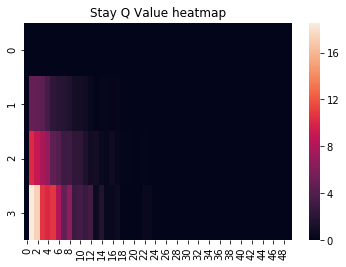

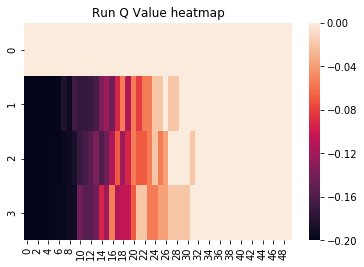

In [52]:
# plt.plot(rews,label = 'reward')
# plt.plot(actions,label = 'actions')
# plt.legend()
# plt.figure()
n = 50
# smoothed_prts = [np.mean(det_env.PRTs[i * n:(i + 1) * n]) for i in range((len(det_env.PRTs) + n - 1) // n )]

# plt.plot(smoothed_prts,label = 'PRTs')
plt.figure()
plt.title('Stay Q Value heatmap')
sns.heatmap(det_agent.q_table[0])
plt.figure()
plt.title('Run Q Value heatmap')
sns.heatmap(det_agent.q_table[1])


array([[0.84017595, 0.7170088 , 0.60557185, 0.52346041, 0.44134897,
        0.37243402, 0.31085044, 0.27565982, 0.228739  , 0.20381232,
        0.17595308, 0.14809384, 0.12170088, 0.09824047, 0.08211144,
        0.06891496, 0.05131965, 0.04252199, 0.03812317, 0.02639296,
        0.02199413, 0.01466276, 0.01026393, 0.0058651 , 0.00439883,
        0.00293255, 0.00293255, 0.00146628, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

array([[0.86343612, 0.73127753, 0.61674009, 0.53744493, 0.46696035,
        0.39941263, 0.3318649 , 0.2804699 , 0.2349486 , 0.19676946,
        0.17033774, 0.14684288, 0.12628488, 0.11013216, 0.08810573,
        0.07048458, 0.05873715, 0.05286344, 0.03964758, 0.030837  ,
        0.02643172, 0.020558  , 0.01468429, 0.010279  , 0.00881057,
        0.00440529, 0.00146843, 0.00146843, 0.00146843, 0.00146843,
        0.00146843, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

array([[0.84458399, 0.72527473, 0.61067504, 0.52904239, 0.44583987,
        0.38147567, 0.32653061, 0.2700157 , 0.22291994, 0.17582418,
        0.15698587, 0.13500785, 0.11302983, 0.09419152, 0.08477237,
        0.07064364, 0.06593407, 0.0533752 , 0.04238619, 0.03139717,
        0.02511774, 0.02354788, 0.02197802, 0.01726845, 0.01255887,
        0.00941915, 0.00627943, 0.00470958, 0.00313972, 0.00156986,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

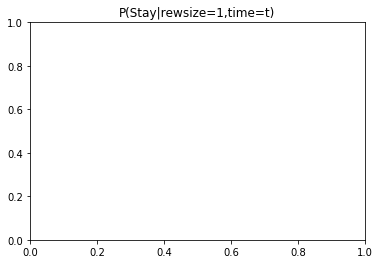

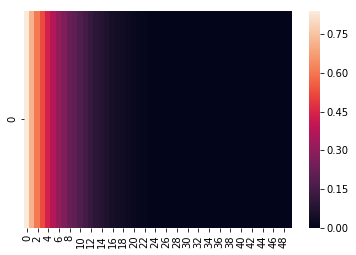

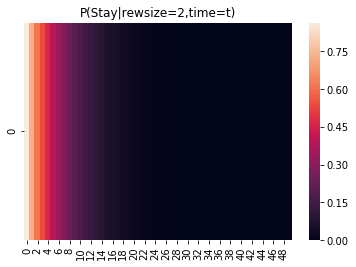

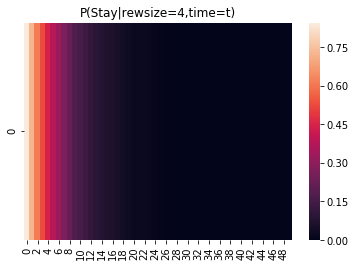

In [51]:
# currently no differentiation between reward sizes because there's nothing different happening in the q value propagation
# - probably should implement some TD lambda
plt.title('P(Stay|rewsize=1,time=t)')
sns.heatmap((np.sum(np.array(behavior_mats[1]),axis = 0)/len(behavior_mats[1]))[np.newaxis,:])
display((np.sum(np.array(behavior_mats[1]),axis = 0)/len(behavior_mats[1]))[np.newaxis,:])
plt.figure()
plt.title('P(Stay|rewsize=2,time=t)')
sns.heatmap((np.sum(np.array(behavior_mats[2]),axis = 0)/len(behavior_mats[2]))[np.newaxis,:])
display(((np.sum(np.array(behavior_mats[2]),axis = 0)/len(behavior_mats[2]))[np.newaxis,:]))
plt.figure()
plt.title('P(Stay|rewsize=4,time=t)')
sns.heatmap((np.sum(np.array(behavior_mats[3]),axis = 0)/len(behavior_mats[3]))[np.newaxis,:])
display(((np.sum(np.array(behavior_mats[3]),axis = 0)/len(behavior_mats[3]))[np.newaxis,:]))

In [86]:
N0 = [.5, .25, .125]
pdfs = dict()
for n0 in N0:
    x = list(map(cdf,list(range(50)),np.full(50,n0)))
    pdfs[n0] = pdf(x)
    
    
# Poisson process of reward location selection

np.where(rnd.random(50) - pdfs[.25] < 0)[0].tolist()
pdfs

{0.5: [1,
  0.4700123896616182,
  0.4147844780527623,
  0.36604601712173057,
  0.32303447631335525,
  0.2850769247745726,
  0.25157950311190236,
  0.22201813225002498,
  0.19593031402826444,
  0.17290789525237038,
  0.15259068199263837,
  0.13466080422177473,
  0.11883774262526625,
  0.10487393977694381,
  0.09255092701499557,
  0.08167590642206601,
  0.07207873443326296,
  0.06360925987957256,
  0.05613497481942087,
  0.04953894140480397,
  0.043717962347058936,
  0.03858096635858921,
  0.03404758331017543,
  0.03004688681172052,
  0.026516284543653512,
  0.023400538977826457,
  0.02065090316674212,
  0.01822435808022327,
  0.01608293955739004,
  0.014193144343852104,
  0.012525405921385513,
  0.011053631929237362,
  0.009754795939862504,
  0.00860857720227326,
  0.00759704271666628,
  0.006704366666261841,
  0.005916582816766436,
  0.005221366009681816,
  0.004607839330804886,
  0.004066403937042828,
  0.0035885888790971876,
  0.003166918570453703,
  0.002794795829163199,
  0.0024663

So we're going to deliver our rewards at 0, 4, and 16 seconds

In [60]:
a = np.random.random((5,5))
display(a)
a[tuple([4,1])]

array([[0.1047235 , 0.07478367, 0.87633942, 0.7541277 , 0.68988409],
       [0.13054263, 0.19060027, 0.42292231, 0.54175223, 0.82974886],
       [0.95295739, 0.19458032, 0.06742969, 0.84323411, 0.36842965],
       [0.65423782, 0.74009388, 0.73158795, 0.91336424, 0.5246009 ],
       [0.11132019, 0.99311663, 0.14763075, 0.26944768, 0.45315311]])

0.9931166326497026